# Module - 2
# Predicting LogS and LogP using ANN and molecular fingerprint of molecule

## Importing required libraries

In [118]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import pickle
import os
import requests
from io import StringIO

warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Chemistry
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdDistGeom
from rdkit.Chem.rdForceFieldHelpers import UFFOptimizeMolecule
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'GPU' if torch.cuda.is_available() else 'CPU'}")

All libraries imported successfully!
PyTorch version: 2.2.0+cu121
Device available: GPU


# Loading and analysing ESol dataset

Loaded ESOL with 1128 compounds
Columns in dataset: ['Compound ID', 'ESOL predicted log solubility in mols per litre', 'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area', 'measured log solubility in mols per litre', 'smiles']
Dataset shape: (1128, 3)
LogS range: -11.60 to 1.58

Sample data:
                                              SMILES  LogS  \
0  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)... -0.77   
1                             Cc1occc1C(=O)Nc2ccccc2 -3.30   
2                               CC(C)=CCCC(C)=CC(=O) -2.06   
3                 c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43 -7.87   
4                                            c1ccsc1 -1.33   

   ESol_Predicted_LogS  
0               -0.974  
1               -2.885  
2               -2.579  
3               -6.618  
4               -2.232  


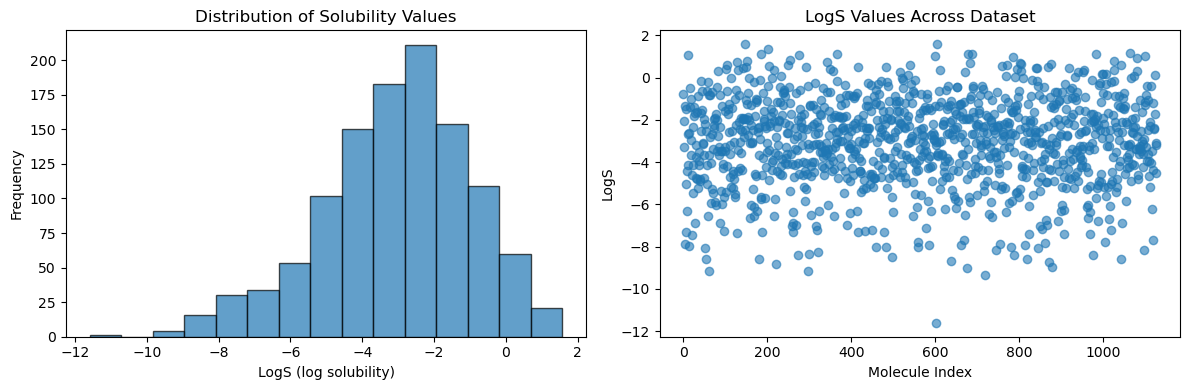

In [119]:

def load_esol_dataset():
    """Load the ESOL (Delaney) solubility dataset"""
    url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"
    response = requests.get(url)
    response.raise_for_status()

    df = pd.read_csv(StringIO(response.text))
    print(f"Loaded ESOL with {len(df)} compounds")
    print("Columns in dataset:", df.columns.tolist())
    # Use 'smiles' and 'measured log solubility in mols per litre'
    df = df[['smiles', 'measured log solubility in mols per litre','ESOL predicted log solubility in mols per litre']]
    df.columns = ['SMILES', 'LogS','ESol_Predicted_LogS']

    # Remove invalid SMILES
    valid_smiles = []
    for smiles in df['SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        valid_smiles.append(mol is not None)

    df = df[valid_smiles].reset_index(drop=True)

    return df

# Load dataset
df = load_esol_dataset()
print(f"Dataset shape: {df.shape}")
print(f"LogS range: {df['LogS'].min():.2f} to {df['LogS'].max():.2f}")
print("\nSample data:")
print(df.head())

# Visualize distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['LogS'], bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('LogS (log solubility)')
plt.ylabel('Frequency')
plt.title('Distribution of Solubility Values')

plt.subplot(1, 2, 2)
plt.scatter(range(len(df)), df['LogS'], alpha=0.6)
plt.xlabel('Molecule Index')
plt.ylabel('LogS')
plt.title('LogS Values Across Dataset')
plt.tight_layout()
plt.show()

## Calculating LogP values for molecules

In [120]:
logp_values =[]
for smile in df['SMILES']:
    mol = Chem.MolFromSmiles(smile)
    if mol:
        logp = Descriptors.MolLogP(mol)
        logp_values.append(logp)
    else:
        logp_values.append(np.nan)
logp_values = np.array(logp_values)
df['LogP'] = logp_values

## Visualising distribution of LogP values

LogP range: -7.57 to 10.39


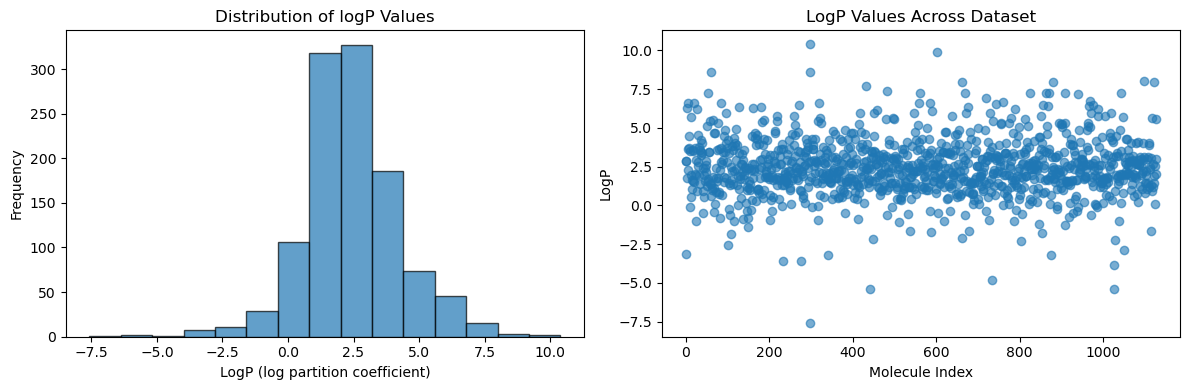

In [121]:
# Visualize distribution
print(f"LogP range: {df['LogP'].min():.2f} to {df['LogP'].max():.2f}")
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['LogP'], bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('LogP (log partition coefficient)')
plt.ylabel('Frequency')
plt.title('Distribution of logP Values')

plt.subplot(1, 2, 2)
plt.scatter(range(len(df)), df['LogP'], alpha=0.6)
plt.xlabel('Molecule Index')
plt.ylabel('LogP')
plt.title('LogP Values Across Dataset')
plt.tight_layout()
plt.show()

## Errors in ESol predicted values

The authors of the paper used a linear regression model to predict LogS values.

In [122]:
#Errors in model used by authors of ESol paper
ESol_mse = mean_squared_error(df['LogS'], df['ESol_Predicted_LogS'])
print(f"ESOL MSE: {ESol_mse:.4f}")
ESol_mae = mean_absolute_error(df['LogS'], df['ESol_Predicted_LogS'])
print(f"ESOL MAE: {ESol_mae:.4f}")
ESol_r2 = r2_score(df['LogS'], df['ESol_Predicted_LogS'])
print(f"ESOL R^2: {ESol_r2:.4f}")

ESOL MSE: 0.8283
ESOL MAE: 0.6979
ESOL R^2: 0.8114


In [123]:
results = {} #disctionary to store results of different models

## Relevant hyperparamters in nb

In [124]:
fpSize = 2048 #morgan fingerprint size (can try : 128,512,1024) --> if you change this,also change the model architecture as required
max_radius = 3 #  #max radius for morgan fingerprint (can try : 2,4,5)
batch_size = 1 #batch size for training (can try : 16,32,64)
num_epochs = 100 #number of epochs
weight_decay = 1e-3 #coefficient to be used in regularisation
lr = 1e-3 #learning rate
patience = 3 #number of epochs to wait before reducing learning rate
factor = 0.5 #factor by which to reduce learning rate
early_stopping_patience = 10 #number of epochs to wait before stopping training if validation loss does not improve
dropout_rate = 0.2 #dropout rate for regularisation

## Generating fingerprints

In [125]:
fingerprints =[] #for morgan fingerprints of len 512
fingerprints_2048 = [] # for morgan fingerprints of len 2048
maccs = [] # for MACCS keys
#the fingerprints are explained below
for smile in df["SMILES"]:
    mol = Chem.MolFromSmiles(smile)
    fpgen = AllChem.GetMorganGenerator(fpSize=fpSize, radius=max_radius)
    morganfp = np.array(fpgen.GetFingerprint(mol))
    maccsfp = np.array(MACCSkeys.GenMACCSKeys(mol))
    fingerprints.append(morganfp)
    maccs.append(maccsfp)
df["morgan"]=fingerprints
df["maccs"]=maccs
df

,SMILES,LogS,ESol_Predicted_LogS,LogP,morgan,maccs
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.770,-0.974,-3.10802,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Cc1occc1C(=O)Nc2ccccc2,-3.300,-2.885,2.84032,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CC(C)=CCCC(C)=CC(=O),-2.060,-2.579,2.87800,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.870,-6.618,6.29940,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,c1ccsc1,-1.330,-2.232,1.74810,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
1123,FC(F)(F)C(Cl)Br,-1.710,-2.608,2.50850,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1124,CNC(=O)ON=C(SC)C(=O)N(C)C,0.106,-0.908,0.10710,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1125,CCSCCSP(=S)(OC)OC,-3.091,-3.323,2.99000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1126,CCC(C)C,-3.180,-2.245,2.05240,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# ANN Using Morgan Fingerprints

 First, we will use Morgan fingerprint as input to ANN. Morgan Fingerprint works by iterating through different atoms, and through substructures around them for different radii( up till max radii), and then hashing these substructures and turning on bit in bit vector at corresponding position. 

 __Relevant Hyperparameter : Fingerprint Size and max_radius__

 If fingerprint size is large,then more substructures can be encoded with less collisions, while if fingerprint size is less, then collisions are more likely but model is smaller(less parameters) and hence can be trained using less compute and data ,faster.

 Max_radius defines the maximum radius upto which substructures are considered for fingerprint. By default it is set to 3.

 Feel free to play around with the hyperparameters.

## Defining PyTorch Dataset class
In pytorch, we need to define a dataset class with functions : __init()__,__len()__,__getitem()__

In [126]:
class FPDataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        return self.x[index],self.y[index]
X_train, X_test, y_train, y_test = train_test_split(
    df['morgan'].values, df[['LogS','LogP']].values, #as we are predicting both LogS and LogP
    test_size=0.2, random_state=42
)
train_dataset = FPDataset(X_train,y_train)
test_dataset = FPDataset(X_test,y_test)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle = True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle = False)


# Defining Models

Simple ANN with just 1 hidden layer with 512 neurons.

In [127]:
class ANN1(nn.Module):
    def __init__(self,input_channels=2048,num_classes=2):
        super(ANN1, self).__init__()
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_channels,512), #hidden layer 1
            nn.ReLU(),
            nn.Dropout(dropout_rate), #dropout for regularisation
            nn.Linear(512,2), # 2 outputs - logS and logP
        )
    def forward(self,x):
        y = self.regressor(x)
        return y

Simple ANN with 2 hidden layers :

Hidden layer 1 - 512 neurons

Hidden layer 2 - 128 neurons

In [128]:
class ANN2(nn.Module):
    def __init__(self,input_channels=2048,num_classes=2):
        super(ANN2, self).__init__()
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_channels,512), #hidden layer 1
            nn.ReLU(),
            nn.Dropout(dropout_rate), #dropout for regularisation
            nn.Linear(512,128), #hidden layer 2
            nn.ReLU(),
            nn.Dropout(dropout_rate), #dropout for regularisation
            nn.Linear(128,2),
        )
    def forward(self,x):
        y = self.regressor(x)
        return y

Simple ANN with 3 hidden layers : 

Hidden layer 1 - 512 neurons

Hidden layer 2 - 128 neurons

Hidden layer 3 - 32 neurons

In [129]:
class ANN3(nn.Module):
    def __init__(self,input_channels=2048,num_classes=2):
        super(ANN3, self).__init__()
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_channels,512), #hidden layer 1
            nn.ReLU(),
            nn.Dropout(dropout_rate), #dropout for regularisation
            nn.Linear(512,128), #hidden layer 2
            nn.ReLU(),
            nn.Dropout(dropout_rate), #dropout for regularisation
            nn.Linear(128,32), #hidden layer 3
            nn.ReLU(),
            nn.Dropout(dropout_rate), #dropout for regularisation
            nn.Linear(32,2), # 2 outputs - logS and logP
        )
    def forward(self,x):
        y = self.regressor(x)
        return y

GPU are preferred for training models as they are faster.

In [130]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ANN1(input_channels=2048).to(device)
print(device)
# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

cuda
Total parameters: 1,050,114
Trainable parameters: 1,050,114


## Training loop (model with 1 hidden layer)
Relevant hyperparameters : 

num_epochs = number of epochs

weight_decay = coefficient to be used in regularisation

lr = learning rate

In [131]:
def train_model_regression(model,train_loader,test_loader,num_epochs=num_epochs,lr=lr):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay) #weight decay for regularisation
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience, factor=factor) #reduce learning rate by 0.5 if validation loss does not improve for 3 epochs
    train_losses = [] #list to store training losses
    train_logs_losses = [] #list to store training losses for logs
    train_logp_losses = [] #list to store training losses for logp
    all_predictions = [] #list to store predictions
    all_logs = [] #list to store true values
    test_losses = [] #list to store test losses
    test_logs_losses = [] #list to store test losses for logs
    test_logp_losses = [] #list to store test losses for logp
    test_r2_scores = [] #list to store test r2 scores - r2 score is a measure of how much of the veriance in the target variable is explained by the model
    early_stopping_counter = 0  # Counter for early stopping
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        running_loss_logS = 0.0
        running_loss_logP = 0.0
        for fp,logs in tqdm(train_loader,desc="training"):
            logs = logs.float()
            fp = fp.float()
            fp , logs = fp.to(device) , logs.to(device)
            optimizer.zero_grad() # Zero the gradients,or else they will keep accumulating
            outputs = model(fp)
            loss_logS = criterion(outputs[:, 0], logs[:, 0])  # LogS loss
            loss_logP = criterion(outputs[:, 1], logs[:, 1])  # LogP loss
            loss = loss_logS + loss_logP  # Total loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_loss_logS += loss_logS.item()
            running_loss_logP += loss_logP.item()
        train_loss = running_loss / len(train_loader)
        train_loss_logS = running_loss_logS / len(train_loader)
        train_loss_logP = running_loss_logP / len(train_loader)
        # Validation
        model.eval() #disables dropout
        test_loss = 0.0
        test_loss_logS = 0.0
        test_loss_logP = 0.0
        all_predictions = []
        all_logs = []
        with torch.no_grad():
            for fp,logs in tqdm(test_loader,desc="testing"):
                logs = logs.float()
                fp = fp.float()
                fp , logs = fp.to(device) , logs.to(device)
                outputs = model(fp)
                loss_logS = criterion(outputs[:, 0], logs[:, 0])  # LogS loss
                loss_logP = criterion(outputs[:, 1], logs[:, 1])  # LogP loss
                loss = loss_logS + loss_logP  # Total loss
                test_loss += loss.item()
                test_loss_logS += loss_logS.item()
                test_loss_logP += loss_logP.item()
                all_predictions.extend(outputs.cpu().numpy())
                all_logs.extend(logs.cpu().numpy())
            test_loss = test_loss / len(test_loader)
            test_loss_logS = test_loss_logS / len(test_loader)
            test_loss_logP = test_loss_logP / len(test_loader)
            r2 = r2_score(all_logs, all_predictions)
            scheduler.step(test_loss)
            if(epoch>0):
                if test_loss > test_losses[-1]:  # Check if the test loss has increased
                    early_stopping_counter += 1
                elif abs(test_loss - test_losses[-1]) < 1e-4:  # Check if the test loss has not changed significantly
                    early_stopping_counter += 1
                else:
                    early_stopping_counter = 0
                if test_loss < min(test_losses):
                    torch.save(model.state_dict(), 'curr_ann.pth')  # Save the best model
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1} due to no improvement in test loss.")
                break
            # Store metrics
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            test_r2_scores.append(r2)
            train_logs_losses.append(train_loss_logS)
            train_logp_losses.append(train_loss_logP)
            test_logs_losses.append(test_loss_logS)
            test_logp_losses.append(test_loss_logP)

            print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Test Loss: {test_loss:.4f}, '
              f'Test R²: {r2:.4f}, ')
            
                
              

    return train_losses, test_losses, test_r2_scores, train_logs_losses, train_logp_losses, test_logs_losses, test_logp_losses

train_losses, test_losses, test_r2_scores,train_logs_losses,train_logp_losses, test_logs_losses, test_logp_losses=train_model_regression(model,train_loader,test_loader,100)



testing: 100%|██████████| 226/226 [00:00<00:00, 1421.05it/s]


Epoch [1/100], Train Loss: 4.4660, Test Loss: 2.9150, Test R²: 0.6590, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1368.97it/s]


Epoch [2/100], Train Loss: 2.0551, Test Loss: 2.2761, Test R²: 0.7364, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1760.28it/s]


Epoch [3/100], Train Loss: 1.3787, Test Loss: 2.3571, Test R²: 0.7248, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2358.19it/s]


Epoch [4/100], Train Loss: 1.0507, Test Loss: 2.1778, Test R²: 0.7469, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2110.76it/s]


Epoch [5/100], Train Loss: 0.9735, Test Loss: 2.0459, Test R²: 0.7613, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2065.57it/s]


Epoch [6/100], Train Loss: 0.8533, Test Loss: 1.8730, Test R²: 0.7820, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2056.85it/s]


Epoch [7/100], Train Loss: 0.8187, Test Loss: 1.8567, Test R²: 0.7848, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2148.25it/s]


Epoch [8/100], Train Loss: 0.7228, Test Loss: 1.9711, Test R²: 0.7710, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2353.76it/s]


Epoch [9/100], Train Loss: 0.9129, Test Loss: 1.8696, Test R²: 0.7846, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2252.32it/s]


Epoch [10/100], Train Loss: 0.7413, Test Loss: 1.8161, Test R²: 0.7889, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1220.63it/s]


Epoch [11/100], Train Loss: 0.7241, Test Loss: 1.7604, Test R²: 0.7959, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1466.52it/s]


Epoch [12/100], Train Loss: 0.6948, Test Loss: 2.1122, Test R²: 0.7551, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2289.48it/s]


Epoch [13/100], Train Loss: 0.7244, Test Loss: 1.6248, Test R²: 0.8107, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2419.59it/s]


Epoch [14/100], Train Loss: 0.6566, Test Loss: 1.7631, Test R²: 0.7952, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1867.33it/s]


Epoch [15/100], Train Loss: 0.6819, Test Loss: 1.7472, Test R²: 0.7976, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1561.38it/s]


Epoch [16/100], Train Loss: 0.6725, Test Loss: 1.9363, Test R²: 0.7747, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2100.84it/s]


Epoch [17/100], Train Loss: 0.6653, Test Loss: 1.7895, Test R²: 0.7912, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2271.10it/s]


Epoch [18/100], Train Loss: 0.5495, Test Loss: 1.6183, Test R²: 0.8121, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2288.10it/s]


Epoch [19/100], Train Loss: 0.3308, Test Loss: 1.6806, Test R²: 0.8054, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2365.79it/s]


Epoch [20/100], Train Loss: 0.3600, Test Loss: 1.6383, Test R²: 0.8099, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1906.88it/s]


Epoch [21/100], Train Loss: 0.3475, Test Loss: 1.6768, Test R²: 0.8052, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2344.51it/s]


Epoch [22/100], Train Loss: 0.3655, Test Loss: 1.5638, Test R²: 0.8186, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2487.61it/s]


Epoch [23/100], Train Loss: 0.3621, Test Loss: 1.5339, Test R²: 0.8229, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2504.35it/s]


Epoch [24/100], Train Loss: 0.3774, Test Loss: 1.6749, Test R²: 0.8055, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2435.79it/s]


Epoch [25/100], Train Loss: 0.3650, Test Loss: 1.4670, Test R²: 0.8296, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2312.73it/s]


Epoch [26/100], Train Loss: 0.3691, Test Loss: 1.6854, Test R²: 0.8049, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2114.83it/s]


Epoch [27/100], Train Loss: 0.3511, Test Loss: 1.5960, Test R²: 0.8153, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2301.46it/s]


Epoch [28/100], Train Loss: 0.3683, Test Loss: 1.7275, Test R²: 0.8005, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2414.85it/s]


Epoch [29/100], Train Loss: 0.3740, Test Loss: 1.5885, Test R²: 0.8157, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2389.51it/s]


Epoch [30/100], Train Loss: 0.3625, Test Loss: 1.5127, Test R²: 0.8244, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2036.57it/s]


Epoch [31/100], Train Loss: 0.2648, Test Loss: 1.4629, Test R²: 0.8307, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2487.27it/s]


Epoch [32/100], Train Loss: 0.2504, Test Loss: 1.5909, Test R²: 0.8150, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2462.92it/s]


Epoch [33/100], Train Loss: 0.2612, Test Loss: 1.4826, Test R²: 0.8285, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2351.73it/s]


Epoch [34/100], Train Loss: 0.2347, Test Loss: 1.5067, Test R²: 0.8255, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2444.67it/s]


Epoch [35/100], Train Loss: 0.2670, Test Loss: 1.4808, Test R²: 0.8287, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2549.66it/s]


Epoch [36/100], Train Loss: 0.2352, Test Loss: 1.4614, Test R²: 0.8311, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2403.36it/s]


Epoch [37/100], Train Loss: 0.2091, Test Loss: 1.5125, Test R²: 0.8246, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2368.51it/s]


Epoch [38/100], Train Loss: 0.2110, Test Loss: 1.5241, Test R²: 0.8232, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2212.38it/s]


Epoch [39/100], Train Loss: 0.2230, Test Loss: 1.5264, Test R²: 0.8231, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2291.36it/s]


Epoch [40/100], Train Loss: 0.1884, Test Loss: 1.5171, Test R²: 0.8242, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2088.36it/s]


Epoch [41/100], Train Loss: 0.1782, Test Loss: 1.5551, Test R²: 0.8198, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2287.22it/s]


Epoch [42/100], Train Loss: 0.1671, Test Loss: 1.5472, Test R²: 0.8208, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2316.03it/s]


Epoch [43/100], Train Loss: 0.1813, Test Loss: 1.5296, Test R²: 0.8230, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2326.19it/s]


Epoch [44/100], Train Loss: 0.1662, Test Loss: 1.5383, Test R²: 0.8217, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1339.83it/s]


Epoch [45/100], Train Loss: 0.1800, Test Loss: 1.5440, Test R²: 0.8212, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2211.78it/s]


Epoch [46/100], Train Loss: 0.1683, Test Loss: 1.5416, Test R²: 0.8215, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1613.91it/s]


Epoch [47/100], Train Loss: 0.1713, Test Loss: 1.5350, Test R²: 0.8223, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2037.67it/s]


Epoch [48/100], Train Loss: 0.1654, Test Loss: 1.5273, Test R²: 0.8233, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1514.89it/s]


Epoch [49/100], Train Loss: 0.1730, Test Loss: 1.5270, Test R²: 0.8232, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1482.91it/s]


Epoch [50/100], Train Loss: 0.1525, Test Loss: 1.5303, Test R²: 0.8229, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2110.62it/s]


Epoch [51/100], Train Loss: 0.1603, Test Loss: 1.5364, Test R²: 0.8222, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2203.17it/s]


Epoch [52/100], Train Loss: 0.1605, Test Loss: 1.5332, Test R²: 0.8225, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2033.28it/s]


Epoch [53/100], Train Loss: 0.1595, Test Loss: 1.5323, Test R²: 0.8226, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1909.24it/s]


Epoch [54/100], Train Loss: 0.1383, Test Loss: 1.5300, Test R²: 0.8229, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1918.00it/s]


Epoch [55/100], Train Loss: 0.1547, Test Loss: 1.5331, Test R²: 0.8226, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2092.78it/s]


Epoch [56/100], Train Loss: 0.1468, Test Loss: 1.5328, Test R²: 0.8226, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1979.12it/s]


Epoch [57/100], Train Loss: 0.1450, Test Loss: 1.5335, Test R²: 0.8225, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2018.20it/s]


Epoch [58/100], Train Loss: 0.1386, Test Loss: 1.5358, Test R²: 0.8223, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2192.94it/s]


Epoch [59/100], Train Loss: 0.1472, Test Loss: 1.5360, Test R²: 0.8222, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1692.96it/s]


Epoch [60/100], Train Loss: 0.1487, Test Loss: 1.5387, Test R²: 0.8219, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1998.29it/s]


Epoch [61/100], Train Loss: 0.1488, Test Loss: 1.5388, Test R²: 0.8219, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2000.84it/s]


Epoch [62/100], Train Loss: 0.1429, Test Loss: 1.5405, Test R²: 0.8217, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2105.98it/s]


Epoch [63/100], Train Loss: 0.1471, Test Loss: 1.5409, Test R²: 0.8217, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2133.29it/s]


Epoch [64/100], Train Loss: 0.1516, Test Loss: 1.5405, Test R²: 0.8217, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2057.22it/s]


Epoch [65/100], Train Loss: 0.1592, Test Loss: 1.5406, Test R²: 0.8217, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1785.29it/s]


Epoch [66/100], Train Loss: 0.1581, Test Loss: 1.5407, Test R²: 0.8217, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2146.30it/s]


Epoch [67/100], Train Loss: 0.1656, Test Loss: 1.5410, Test R²: 0.8217, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2215.20it/s]


Epoch [68/100], Train Loss: 0.1518, Test Loss: 1.5409, Test R²: 0.8217, 


testing: 100%|██████████| 226/226 [00:00<00:00, 559.63it/s]


Epoch [69/100], Train Loss: 0.1318, Test Loss: 1.5411, Test R²: 0.8217, 


testing: 100%|██████████| 226/226 [00:00<00:00, 712.36it/s]


Epoch [70/100], Train Loss: 0.1624, Test Loss: 1.5409, Test R²: 0.8217, 


testing: 100%|██████████| 226/226 [00:00<00:00, 443.26it/s]


Epoch [71/100], Train Loss: 0.1381, Test Loss: 1.5410, Test R²: 0.8217, 


testing: 100%|██████████| 226/226 [00:00<00:00, 412.92it/s]


Epoch [72/100], Train Loss: 0.1502, Test Loss: 1.5410, Test R²: 0.8217, 


testing: 100%|██████████| 226/226 [00:00<00:00, 294.01it/s]


Epoch [73/100], Train Loss: 0.1414, Test Loss: 1.5410, Test R²: 0.8217, 


testing: 100%|██████████| 226/226 [00:00<00:00, 365.71it/s]


Epoch [74/100], Train Loss: 0.1406, Test Loss: 1.5410, Test R²: 0.8217, 


testing: 100%|██████████| 226/226 [00:00<00:00, 373.30it/s]


Epoch [75/100], Train Loss: 0.1433, Test Loss: 1.5413, Test R²: 0.8216, 


testing: 100%|██████████| 226/226 [00:00<00:00, 459.15it/s]


Epoch [76/100], Train Loss: 0.1577, Test Loss: 1.5415, Test R²: 0.8216, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1948.99it/s]


Epoch [77/100], Train Loss: 0.1385, Test Loss: 1.5415, Test R²: 0.8216, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1441.97it/s]


Epoch [78/100], Train Loss: 0.1466, Test Loss: 1.5414, Test R²: 0.8216, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1717.96it/s]


Epoch [79/100], Train Loss: 0.1430, Test Loss: 1.5413, Test R²: 0.8216, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1933.77it/s]


Epoch [80/100], Train Loss: 0.1524, Test Loss: 1.5413, Test R²: 0.8216, 


testing: 100%|██████████| 226/226 [00:00<00:00, 432.13it/s]


Epoch [81/100], Train Loss: 0.1560, Test Loss: 1.5413, Test R²: 0.8216, 


testing: 100%|██████████| 226/226 [00:00<00:00, 422.40it/s]


Epoch [82/100], Train Loss: 0.1478, Test Loss: 1.5414, Test R²: 0.8216, 


testing: 100%|██████████| 226/226 [00:00<00:00, 424.60it/s]


Epoch [83/100], Train Loss: 0.1452, Test Loss: 1.5413, Test R²: 0.8216, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1776.76it/s]


Epoch [84/100], Train Loss: 0.1440, Test Loss: 1.5414, Test R²: 0.8216, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1810.51it/s]


Epoch [85/100], Train Loss: 0.1481, Test Loss: 1.5414, Test R²: 0.8216, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2082.73it/s]


Epoch [86/100], Train Loss: 0.1441, Test Loss: 1.5414, Test R²: 0.8216, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1265.88it/s]


Epoch [87/100], Train Loss: 0.1597, Test Loss: 1.5414, Test R²: 0.8216, 


testing: 100%|██████████| 226/226 [00:00<00:00, 624.37it/s]


Epoch [88/100], Train Loss: 0.1597, Test Loss: 1.5414, Test R²: 0.8216, 


testing: 100%|██████████| 226/226 [00:00<00:00, 290.79it/s]


Early stopping at epoch 89 due to no improvement in test loss.


## Visualising results

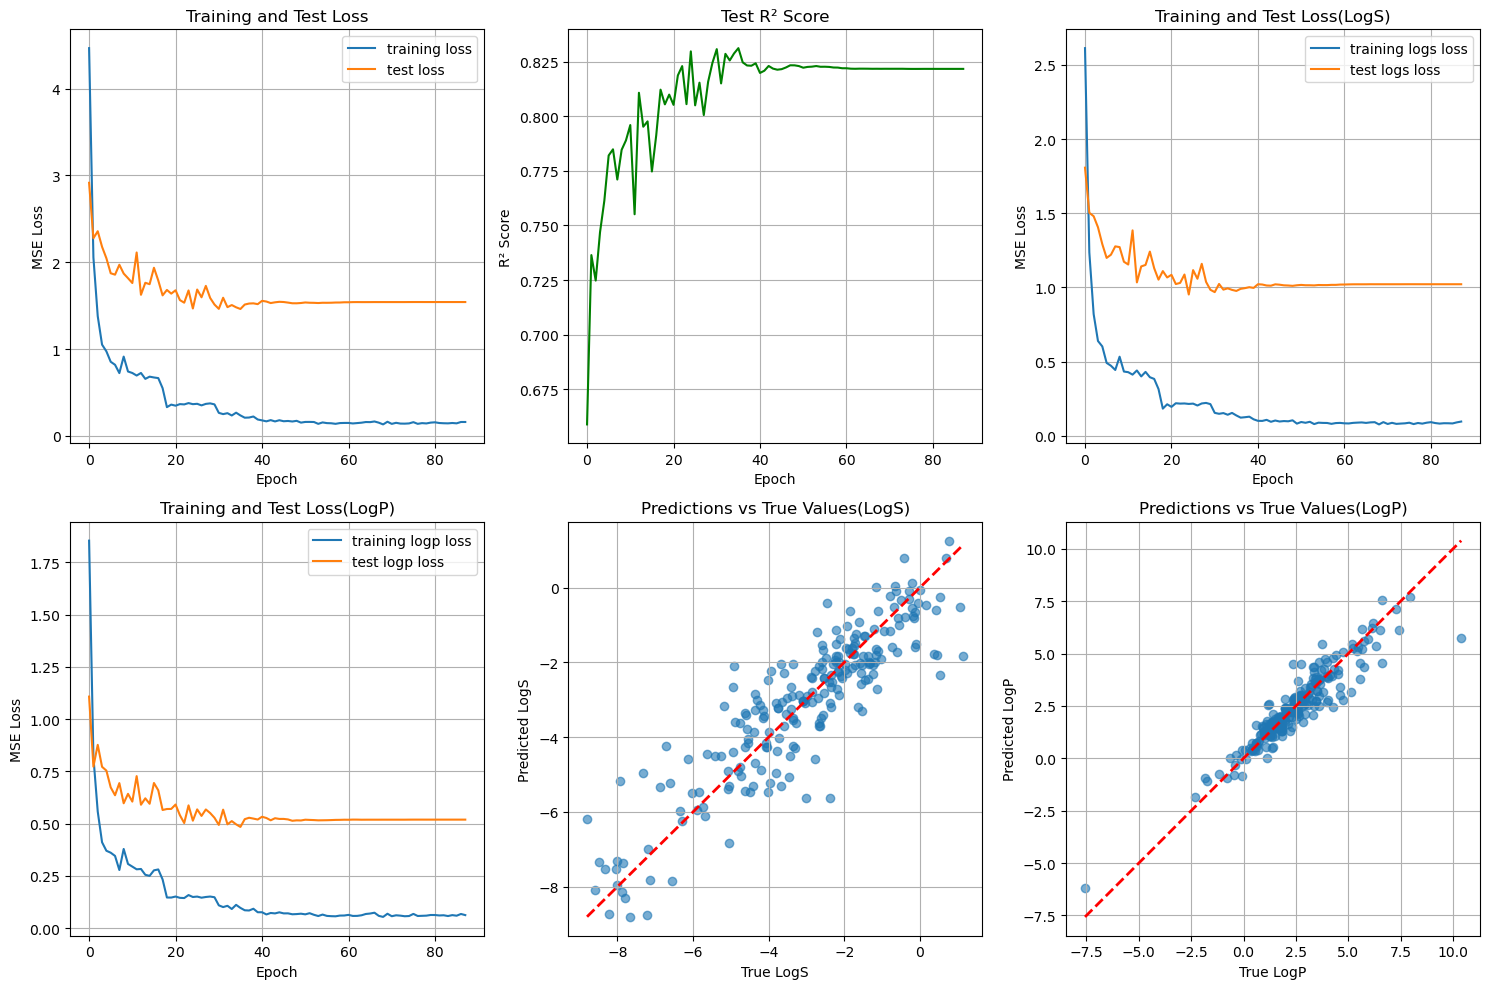

In [132]:


plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.plot(train_losses,label="training loss")
plt.plot(test_losses,label = "test loss")
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(test_r2_scores, label='Test R²', color='green')
plt.title('Test R² Score')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(train_logs_losses,label="training logs loss")
plt.plot(test_logs_losses,label = "test logs loss")
plt.title('Training and Test Loss(LogS)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(train_logp_losses,label="training logp loss")
plt.plot(test_logp_losses,label = "test logp loss")
plt.title('Training and Test Loss(LogP)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
# Final predictions vs actual
model = ANN1(input_channels=2048).to(device)
model.load_state_dict(torch.load('curr_ann.pth',weights_only=True))  # Load the best model
torch.save(model.state_dict(), 'ann1.pth')  # Save the best model
model.eval()
final_predictions = []
final_labels = []

with torch.no_grad():
    for fp, labels in test_loader:
        fp , labels = fp.float() , labels.float()
        fp, labels = fp.to(device), labels.to(device)
        outputs = model(fp)
        final_predictions.extend(outputs.cpu().numpy())
        final_labels.extend(labels.cpu().numpy())
final_predictions = np.array(final_predictions)
final_labels = np.array(final_labels)


plt.subplot(2, 3, 5)
plt.scatter(final_labels[:,0], final_predictions[:,0], alpha=0.6)
plt.plot([min(final_labels[:,0]), max(final_labels[:,0])],
         [min(final_labels[:,0]), max(final_labels[:,0])], 'r--', lw=2)
plt.xlabel('True LogS')
plt.ylabel('Predicted LogS')
plt.title('Predictions vs True Values(LogS)')
plt.grid(True)

plt.subplot(2, 3, 6)
plt.scatter(final_labels[:,1], final_predictions[:,1], alpha=0.6)
plt.plot([min(final_labels[:,1]), max(final_labels[:,1])],
         [min(final_labels[:,1]), max(final_labels[:,1])], 'r--', lw=2)
plt.xlabel('True LogP')
plt.ylabel('Predicted LogP')
plt.title('Predictions vs True Values(LogP)')
plt.grid(True)

plt.tight_layout()
plt.show()

## Stroring Results


In [133]:
mae_logs = mean_absolute_error(final_labels[:,0], final_predictions[:,0])
print(f"MAE for LogS: {mae_logs:.4f}")
mae_logp = mean_absolute_error(final_labels[:,1], final_predictions[:,1])
print(f"MAE for LogP: {mae_logp:.4f}")
mse_logs = mean_squared_error(final_labels[:,0], final_predictions[:,0])
print(f"MSE for LogS: {mse_logs:.4f}")
mse_logp = mean_squared_error(final_labels[:,1], final_predictions[:,1])
print(f"MSE for LogP: {mse_logp:.4f}")
r2_logs = r2_score(final_labels[:,0], final_predictions[:,0])
print(f"R² for LogS: {r2_logs:.4f}")
r2_logp = r2_score(final_labels[:,1], final_predictions[:,1])
print(f"R² for LogP: {r2_logp:.4f}")
results['ANN1'] = {'MAE_LogS': mae_logs,'MAE_LogP': mae_logp,'MSE_LogS': mse_logs,'MSE_LogP': mse_logp,'r2_LogS': r2_logs,'r2_LogP': r2_logp}

MAE for LogS: 0.7482
MAE for LogP: 0.4699
MSE for LogS: 0.9767
MSE for LogP: 0.4846
R² for LogS: 0.7934
R² for LogP: 0.8689


## Now, we train the model with 2 hidden layers

In [134]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ANN2(input_channels=2048).to(device)
print(device)
# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

cuda
Total parameters: 1,115,010
Trainable parameters: 1,115,010


In [135]:
train_losses, test_losses, test_r2_scores,train_logs_losses,train_logp_losses, test_logs_losses, test_logp_losses=train_model_regression(model,train_loader,test_loader,100)

testing: 100%|██████████| 226/226 [00:00<00:00, 364.06it/s]


Epoch [1/100], Train Loss: 4.8444, Test Loss: 2.8548, Test R²: 0.6627, 


testing: 100%|██████████| 226/226 [00:00<00:00, 444.94it/s]


Epoch [2/100], Train Loss: 2.5832, Test Loss: 2.2437, Test R²: 0.7396, 


testing: 100%|██████████| 226/226 [00:00<00:00, 366.38it/s]


Epoch [3/100], Train Loss: 2.1990, Test Loss: 2.7673, Test R²: 0.6816, 


testing: 100%|██████████| 226/226 [00:00<00:00, 502.95it/s]


Epoch [4/100], Train Loss: 1.6199, Test Loss: 2.5972, Test R²: 0.6959, 


testing: 100%|██████████| 226/226 [00:00<00:00, 399.53it/s]


Epoch [5/100], Train Loss: 1.5131, Test Loss: 2.2441, Test R²: 0.7380, 


testing: 100%|██████████| 226/226 [00:00<00:00, 362.36it/s]


Epoch [6/100], Train Loss: 1.3242, Test Loss: 2.0313, Test R²: 0.7645, 


testing: 100%|██████████| 226/226 [00:00<00:00, 586.18it/s]


Epoch [7/100], Train Loss: 1.1337, Test Loss: 2.1420, Test R²: 0.7519, 


testing: 100%|██████████| 226/226 [00:00<00:00, 357.21it/s]


Epoch [8/100], Train Loss: 1.1351, Test Loss: 2.0686, Test R²: 0.7574, 


testing: 100%|██████████| 226/226 [00:00<00:00, 577.58it/s]


Epoch [9/100], Train Loss: 1.1211, Test Loss: 2.7389, Test R²: 0.6816, 


testing: 100%|██████████| 226/226 [00:00<00:00, 548.62it/s]


Epoch [10/100], Train Loss: 1.1119, Test Loss: 2.0091, Test R²: 0.7657, 


testing: 100%|██████████| 226/226 [00:00<00:00, 762.45it/s]


Epoch [11/100], Train Loss: 1.1841, Test Loss: 1.8146, Test R²: 0.7891, 


testing: 100%|██████████| 226/226 [00:00<00:00, 388.42it/s]


Epoch [12/100], Train Loss: 0.9859, Test Loss: 2.1030, Test R²: 0.7552, 


testing: 100%|██████████| 226/226 [00:00<00:00, 272.17it/s]


Epoch [13/100], Train Loss: 1.0831, Test Loss: 2.0480, Test R²: 0.7599, 


testing: 100%|██████████| 226/226 [00:00<00:00, 372.86it/s]


Epoch [14/100], Train Loss: 1.1344, Test Loss: 2.0669, Test R²: 0.7594, 


testing: 100%|██████████| 226/226 [00:00<00:00, 348.30it/s]


Epoch [15/100], Train Loss: 0.9232, Test Loss: 1.8641, Test R²: 0.7829, 


testing: 100%|██████████| 226/226 [00:00<00:00, 359.54it/s]


Epoch [16/100], Train Loss: 0.8312, Test Loss: 1.8486, Test R²: 0.7849, 


testing: 100%|██████████| 226/226 [00:00<00:00, 396.10it/s]


Epoch [17/100], Train Loss: 0.5453, Test Loss: 1.7050, Test R²: 0.8029, 


testing: 100%|██████████| 226/226 [00:00<00:00, 470.63it/s]


Epoch [18/100], Train Loss: 0.5670, Test Loss: 1.7662, Test R²: 0.7948, 


testing: 100%|██████████| 226/226 [00:00<00:00, 490.64it/s]


Epoch [19/100], Train Loss: 0.5589, Test Loss: 1.6514, Test R²: 0.8087, 


testing: 100%|██████████| 226/226 [00:00<00:00, 398.77it/s]


Epoch [20/100], Train Loss: 0.5090, Test Loss: 1.6829, Test R²: 0.8051, 


testing: 100%|██████████| 226/226 [00:00<00:00, 358.96it/s]


Epoch [21/100], Train Loss: 0.5676, Test Loss: 1.7934, Test R²: 0.7917, 


testing: 100%|██████████| 226/226 [00:00<00:00, 325.47it/s]


Epoch [22/100], Train Loss: 0.5720, Test Loss: 1.6361, Test R²: 0.8100, 


testing: 100%|██████████| 226/226 [00:00<00:00, 395.74it/s]


Epoch [23/100], Train Loss: 0.5566, Test Loss: 1.5781, Test R²: 0.8161, 


testing: 100%|██████████| 226/226 [00:00<00:00, 339.86it/s]


Epoch [24/100], Train Loss: 0.5451, Test Loss: 1.6643, Test R²: 0.8061, 


testing: 100%|██████████| 226/226 [00:00<00:00, 443.63it/s]


Epoch [25/100], Train Loss: 0.5383, Test Loss: 1.9070, Test R²: 0.7802, 


testing: 100%|██████████| 226/226 [00:00<00:00, 430.58it/s]


Epoch [26/100], Train Loss: 0.5357, Test Loss: 1.7791, Test R²: 0.7942, 


testing: 100%|██████████| 226/226 [00:00<00:00, 386.66it/s]


Epoch [27/100], Train Loss: 0.5425, Test Loss: 1.6812, Test R²: 0.8050, 


testing: 100%|██████████| 226/226 [00:00<00:00, 398.01it/s]


Epoch [28/100], Train Loss: 0.4646, Test Loss: 1.6748, Test R²: 0.8059, 


testing: 100%|██████████| 226/226 [00:00<00:00, 361.88it/s]


Epoch [29/100], Train Loss: 0.3628, Test Loss: 1.6943, Test R²: 0.8032, 


testing: 100%|██████████| 226/226 [00:00<00:00, 530.12it/s]


Epoch [30/100], Train Loss: 0.3642, Test Loss: 1.7984, Test R²: 0.7908, 


testing: 100%|██████████| 226/226 [00:00<00:00, 411.68it/s]


Epoch [31/100], Train Loss: 0.3958, Test Loss: 1.6529, Test R²: 0.8083, 


testing: 100%|██████████| 226/226 [00:00<00:00, 341.04it/s]


Epoch [32/100], Train Loss: 0.3508, Test Loss: 1.6697, Test R²: 0.8063, 


testing: 100%|██████████| 226/226 [00:00<00:00, 450.39it/s]


Epoch [33/100], Train Loss: 0.3104, Test Loss: 1.6561, Test R²: 0.8083, 


testing: 100%|██████████| 226/226 [00:00<00:00, 340.03it/s]


Epoch [34/100], Train Loss: 0.2950, Test Loss: 1.6641, Test R²: 0.8072, 


testing: 100%|██████████| 226/226 [00:00<00:00, 334.80it/s]


Epoch [35/100], Train Loss: 0.2830, Test Loss: 1.6872, Test R²: 0.8045, 


testing: 100%|██████████| 226/226 [00:00<00:00, 350.05it/s]


Epoch [36/100], Train Loss: 0.2959, Test Loss: 1.6521, Test R²: 0.8086, 


testing: 100%|██████████| 226/226 [00:00<00:00, 366.05it/s]


Epoch [37/100], Train Loss: 0.2753, Test Loss: 1.6399, Test R²: 0.8100, 


testing: 100%|██████████| 226/226 [00:00<00:00, 298.59it/s]


Epoch [38/100], Train Loss: 0.2430, Test Loss: 1.6304, Test R²: 0.8111, 


testing: 100%|██████████| 226/226 [00:00<00:00, 369.95it/s]


Epoch [39/100], Train Loss: 0.2639, Test Loss: 1.6447, Test R²: 0.8096, 


testing: 100%|██████████| 226/226 [00:00<00:00, 335.08it/s]


Epoch [40/100], Train Loss: 0.2461, Test Loss: 1.6229, Test R²: 0.8123, 


testing: 100%|██████████| 226/226 [00:00<00:00, 358.11it/s]


Epoch [41/100], Train Loss: 0.2724, Test Loss: 1.6445, Test R²: 0.8097, 


testing: 100%|██████████| 226/226 [00:00<00:00, 363.87it/s]


Epoch [42/100], Train Loss: 0.2647, Test Loss: 1.6607, Test R²: 0.8077, 


testing: 100%|██████████| 226/226 [00:00<00:00, 434.76it/s]


Epoch [43/100], Train Loss: 0.2601, Test Loss: 1.6386, Test R²: 0.8103, 


testing: 100%|██████████| 226/226 [00:00<00:00, 538.27it/s]


Epoch [44/100], Train Loss: 0.2665, Test Loss: 1.6421, Test R²: 0.8099, 


testing: 100%|██████████| 226/226 [00:00<00:00, 326.28it/s]


Epoch [45/100], Train Loss: 0.2686, Test Loss: 1.6399, Test R²: 0.8102, 


testing: 100%|██████████| 226/226 [00:00<00:00, 407.86it/s]


Epoch [46/100], Train Loss: 0.2525, Test Loss: 1.6494, Test R²: 0.8091, 


testing: 100%|██████████| 226/226 [00:00<00:00, 430.64it/s]


Epoch [47/100], Train Loss: 0.2313, Test Loss: 1.6522, Test R²: 0.8088, 


testing: 100%|██████████| 226/226 [00:00<00:00, 418.80it/s]


Epoch [48/100], Train Loss: 0.2235, Test Loss: 1.6460, Test R²: 0.8095, 


testing: 100%|██████████| 226/226 [00:00<00:00, 253.72it/s]


Epoch [49/100], Train Loss: 0.2263, Test Loss: 1.6510, Test R²: 0.8089, 


testing: 100%|██████████| 226/226 [00:00<00:00, 408.62it/s]


Epoch [50/100], Train Loss: 0.2342, Test Loss: 1.6435, Test R²: 0.8098, 


testing: 100%|██████████| 226/226 [00:00<00:00, 411.85it/s]


Epoch [51/100], Train Loss: 0.2237, Test Loss: 1.6376, Test R²: 0.8105, 


testing: 100%|██████████| 226/226 [00:00<00:00, 481.45it/s]


Epoch [52/100], Train Loss: 0.2355, Test Loss: 1.6417, Test R²: 0.8100, 


testing: 100%|██████████| 226/226 [00:00<00:00, 449.06it/s]


Epoch [53/100], Train Loss: 0.2312, Test Loss: 1.6427, Test R²: 0.8099, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1697.31it/s]


Epoch [54/100], Train Loss: 0.2138, Test Loss: 1.6434, Test R²: 0.8099, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1730.70it/s]


Epoch [55/100], Train Loss: 0.2705, Test Loss: 1.6396, Test R²: 0.8103, 


testing: 100%|██████████| 226/226 [00:00<00:00, 881.68it/s]


Epoch [56/100], Train Loss: 0.2369, Test Loss: 1.6386, Test R²: 0.8105, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1688.00it/s]


Epoch [57/100], Train Loss: 0.2299, Test Loss: 1.6384, Test R²: 0.8105, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1686.68it/s]


Epoch [58/100], Train Loss: 0.2380, Test Loss: 1.6383, Test R²: 0.8105, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1566.51it/s]


Epoch [59/100], Train Loss: 0.2343, Test Loss: 1.6384, Test R²: 0.8104, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1753.43it/s]


Epoch [60/100], Train Loss: 0.2465, Test Loss: 1.6385, Test R²: 0.8104, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1698.76it/s]


Epoch [61/100], Train Loss: 0.2196, Test Loss: 1.6385, Test R²: 0.8104, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1650.75it/s]


Epoch [62/100], Train Loss: 0.2410, Test Loss: 1.6375, Test R²: 0.8106, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1696.69it/s]


Epoch [63/100], Train Loss: 0.2669, Test Loss: 1.6378, Test R²: 0.8105, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2068.24it/s]


Epoch [64/100], Train Loss: 0.2547, Test Loss: 1.6382, Test R²: 0.8105, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1887.40it/s]


Epoch [65/100], Train Loss: 0.2307, Test Loss: 1.6381, Test R²: 0.8105, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1962.59it/s]


Epoch [66/100], Train Loss: 0.2517, Test Loss: 1.6381, Test R²: 0.8105, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1641.55it/s]


Epoch [67/100], Train Loss: 0.2292, Test Loss: 1.6381, Test R²: 0.8105, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1536.72it/s]


Epoch [68/100], Train Loss: 0.2375, Test Loss: 1.6382, Test R²: 0.8105, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1489.29it/s]


Epoch [69/100], Train Loss: 0.2339, Test Loss: 1.6384, Test R²: 0.8105, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1577.40it/s]


Epoch [70/100], Train Loss: 0.2354, Test Loss: 1.6385, Test R²: 0.8104, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1739.65it/s]


Epoch [71/100], Train Loss: 0.2244, Test Loss: 1.6387, Test R²: 0.8104, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1998.82it/s]

Early stopping at epoch 72 due to no improvement in test loss.


Visualising the results

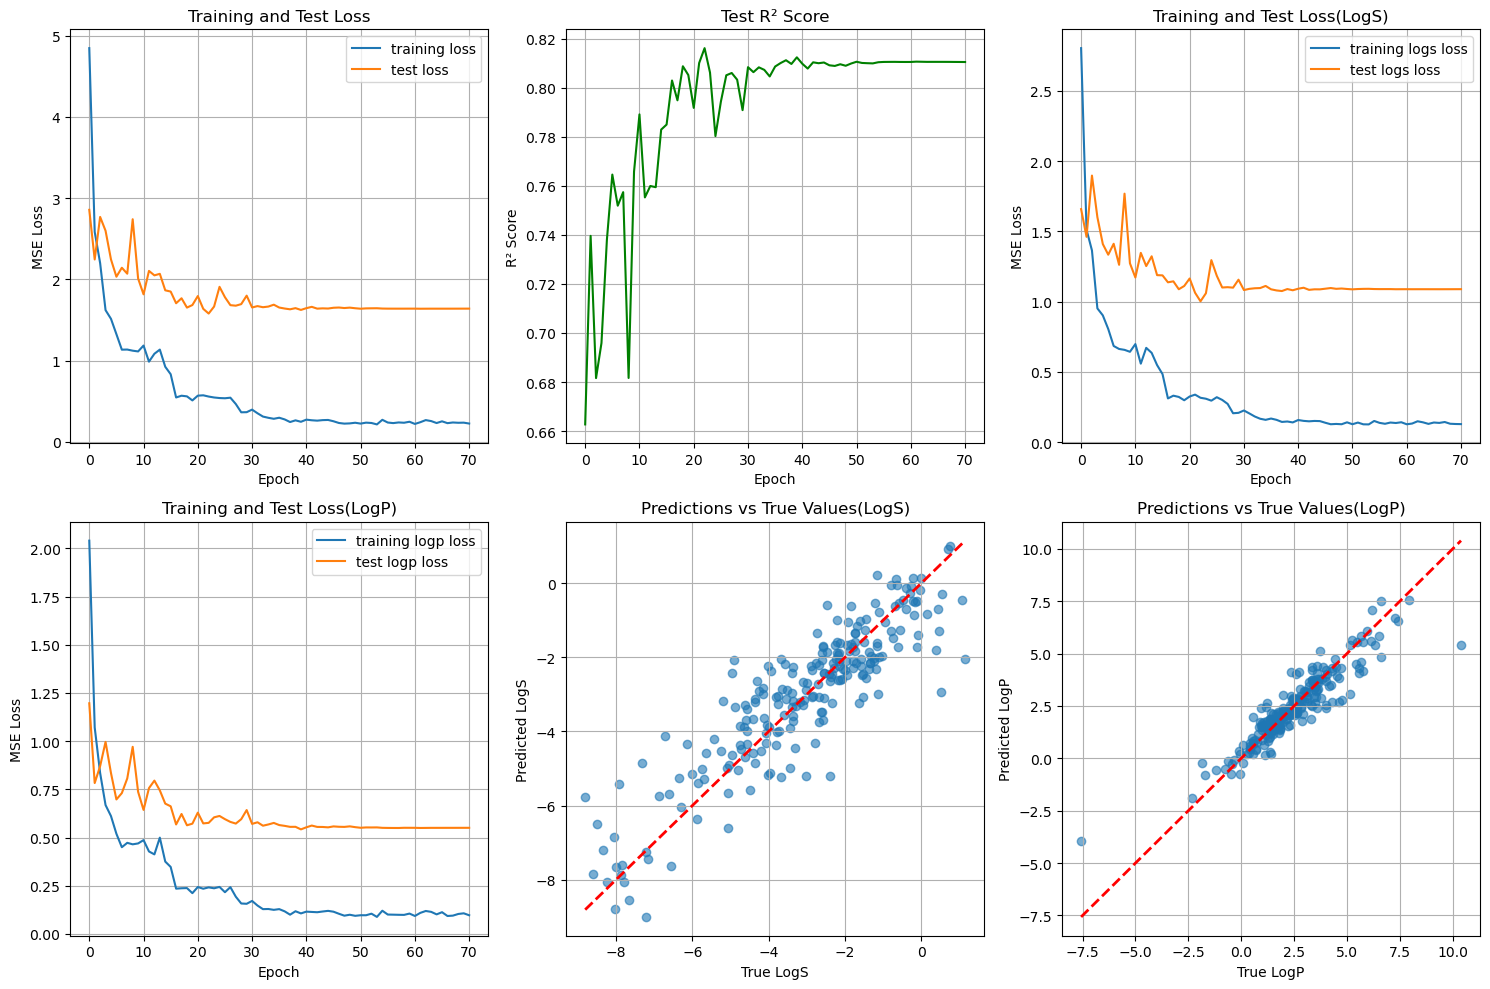

In [136]:


plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.plot(train_losses,label="training loss")
plt.plot(test_losses,label = "test loss")
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(test_r2_scores, label='Test R²', color='green')
plt.title('Test R² Score')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(train_logs_losses,label="training logs loss")
plt.plot(test_logs_losses,label = "test logs loss")
plt.title('Training and Test Loss(LogS)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(train_logp_losses,label="training logp loss")
plt.plot(test_logp_losses,label = "test logp loss")
plt.title('Training and Test Loss(LogP)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
# Final predictions vs actual
model = ANN2(input_channels=2048).to(device)
model.load_state_dict(torch.load('curr_ann.pth',weights_only=True))  # Load the best model
torch.save(model.state_dict(), 'ann2.pth')  # Save the best model
model.eval()
final_predictions = []
final_labels = []

with torch.no_grad():
    for fp, labels in test_loader:
        fp , labels = fp.float() , labels.float()
        fp, labels = fp.to(device), labels.to(device)
        outputs = model(fp)
        final_predictions.extend(outputs.cpu().numpy())
        final_labels.extend(labels.cpu().numpy())
final_predictions = np.array(final_predictions)
final_labels = np.array(final_labels)


plt.subplot(2, 3, 5)
plt.scatter(final_labels[:,0], final_predictions[:,0], alpha=0.6)
plt.plot([min(final_labels[:,0]), max(final_labels[:,0])],
         [min(final_labels[:,0]), max(final_labels[:,0])], 'r--', lw=2)
plt.xlabel('True LogS')
plt.ylabel('Predicted LogS')
plt.title('Predictions vs True Values(LogS)')
plt.grid(True)

plt.subplot(2, 3, 6)
plt.scatter(final_labels[:,1], final_predictions[:,1], alpha=0.6)
plt.plot([min(final_labels[:,1]), max(final_labels[:,1])],
         [min(final_labels[:,1]), max(final_labels[:,1])], 'r--', lw=2)
plt.xlabel('True LogP')
plt.ylabel('Predicted LogP')
plt.title('Predictions vs True Values(LogP)')
plt.grid(True)

plt.tight_layout()
plt.show()

### Storing Results

In [137]:
mae_logs = mean_absolute_error(final_labels[:,0], final_predictions[:,0])
print(f"MAE for LogS: {mae_logs:.4f}")
mae_logp = mean_absolute_error(final_labels[:,1], final_predictions[:,1])
print(f"MAE for LogP: {mae_logp:.4f}")
mse_logs = mean_squared_error(final_labels[:,0], final_predictions[:,0])
print(f"MSE for LogS: {mse_logs:.4f}")
mse_logp = mean_squared_error(final_labels[:,1], final_predictions[:,1])
print(f"MSE for LogP: {mse_logp:.4f}")
r2_logs = r2_score(final_labels[:,0], final_predictions[:,0])
print(f"R² for LogS: {r2_logs:.4f}")
r2_logp = r2_score(final_labels[:,1], final_predictions[:,1])
print(f"R² for LogP: {r2_logp:.4f}")
results['ANN2'] = {'MAE_LogS': mae_logs,'MAE_LogP': mae_logp,'MSE_LogS': mse_logs,'MSE_LogP': mse_logp,'r2_LogS': r2_logs,'r2_LogP': r2_logp}

MAE for LogS: 0.7520
MAE for LogP: 0.5006
MSE for LogS: 1.0020
MSE for LogP: 0.5761
R² for LogS: 0.7880
R² for LogP: 0.8441


## Model with 3 hidden layers

In [138]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ANN3(input_channels=2048).to(device)
print(device)
# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

cuda
Total parameters: 1,118,946
Trainable parameters: 1,118,946


In [139]:
train_losses, test_losses, test_r2_scores,train_logs_losses,train_logp_losses, test_logs_losses, test_logp_losses=train_model_regression(model,train_loader,test_loader,100)

testing: 100%|██████████| 226/226 [00:00<00:00, 1660.10it/s]


Epoch [1/100], Train Loss: 5.7614, Test Loss: 3.0649, Test R²: 0.6347, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1586.33it/s]


Epoch [2/100], Train Loss: 3.5294, Test Loss: 2.8018, Test R²: 0.6719, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1602.44it/s]


Epoch [3/100], Train Loss: 3.1160, Test Loss: 2.1813, Test R²: 0.7454, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1189.80it/s]


Epoch [4/100], Train Loss: 2.4417, Test Loss: 2.5273, Test R²: 0.7056, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1863.24it/s]


Epoch [5/100], Train Loss: 2.3414, Test Loss: 2.4223, Test R²: 0.7183, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1607.16it/s]


Epoch [6/100], Train Loss: 1.8930, Test Loss: 2.4788, Test R²: 0.7111, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1150.69it/s]


Epoch [7/100], Train Loss: 1.9000, Test Loss: 2.4213, Test R²: 0.7203, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1653.20it/s]


Epoch [8/100], Train Loss: 1.5264, Test Loss: 1.7989, Test R²: 0.7906, 


testing: 100%|██████████| 226/226 [00:00<00:00, 403.73it/s]


Epoch [9/100], Train Loss: 1.1930, Test Loss: 1.9727, Test R²: 0.7698, 


testing: 100%|██████████| 226/226 [00:00<00:00, 258.83it/s]


Epoch [10/100], Train Loss: 1.2586, Test Loss: 2.0059, Test R²: 0.7681, 


testing: 100%|██████████| 226/226 [00:00<00:00, 273.94it/s]


Epoch [11/100], Train Loss: 1.2864, Test Loss: 2.0021, Test R²: 0.7685, 


testing: 100%|██████████| 226/226 [00:00<00:00, 266.43it/s]


Epoch [12/100], Train Loss: 1.0444, Test Loss: 1.7744, Test R²: 0.7941, 


testing: 100%|██████████| 226/226 [00:00<00:00, 279.69it/s]


Epoch [13/100], Train Loss: 1.0076, Test Loss: 1.7759, Test R²: 0.7934, 


testing: 100%|██████████| 226/226 [00:00<00:00, 235.29it/s]


Epoch [14/100], Train Loss: 1.0132, Test Loss: 1.7168, Test R²: 0.8010, 


testing: 100%|██████████| 226/226 [00:00<00:00, 289.11it/s]


Epoch [15/100], Train Loss: 0.9807, Test Loss: 1.8306, Test R²: 0.7861, 


testing: 100%|██████████| 226/226 [00:00<00:00, 342.59it/s]


Epoch [16/100], Train Loss: 0.9517, Test Loss: 1.8251, Test R²: 0.7879, 


testing: 100%|██████████| 226/226 [00:00<00:00, 533.85it/s]


Epoch [17/100], Train Loss: 0.8713, Test Loss: 1.8149, Test R²: 0.7899, 


testing: 100%|██████████| 226/226 [00:00<00:00, 373.21it/s]


Epoch [18/100], Train Loss: 0.9970, Test Loss: 1.8454, Test R²: 0.7851, 


testing: 100%|██████████| 226/226 [00:00<00:00, 359.43it/s]


Epoch [19/100], Train Loss: 0.8713, Test Loss: 1.9453, Test R²: 0.7729, 


testing: 100%|██████████| 226/226 [00:00<00:00, 396.67it/s]


Epoch [20/100], Train Loss: 0.7179, Test Loss: 1.7723, Test R²: 0.7952, 


testing: 100%|██████████| 226/226 [00:00<00:00, 435.12it/s]


Epoch [21/100], Train Loss: 0.7075, Test Loss: 1.7061, Test R²: 0.8021, 


testing: 100%|██████████| 226/226 [00:00<00:00, 348.80it/s]


Epoch [22/100], Train Loss: 0.6268, Test Loss: 1.7545, Test R²: 0.7959, 


testing: 100%|██████████| 226/226 [00:00<00:00, 361.88it/s]


Epoch [23/100], Train Loss: 0.7786, Test Loss: 1.7246, Test R²: 0.8015, 


testing: 100%|██████████| 226/226 [00:00<00:00, 304.33it/s]


Epoch [24/100], Train Loss: 0.7110, Test Loss: 1.8465, Test R²: 0.7866, 


testing: 100%|██████████| 226/226 [00:00<00:00, 464.60it/s]


Epoch [25/100], Train Loss: 0.6775, Test Loss: 1.7390, Test R²: 0.7993, 


testing: 100%|██████████| 226/226 [00:00<00:00, 241.36it/s]


Epoch [26/100], Train Loss: 0.6538, Test Loss: 1.6762, Test R²: 0.8064, 


testing: 100%|██████████| 226/226 [00:00<00:00, 281.45it/s]


Epoch [27/100], Train Loss: 0.5585, Test Loss: 1.7177, Test R²: 0.8013, 


testing: 100%|██████████| 226/226 [00:00<00:00, 315.07it/s]


Epoch [28/100], Train Loss: 0.5221, Test Loss: 1.7660, Test R²: 0.7951, 


testing: 100%|██████████| 226/226 [00:00<00:00, 290.94it/s]


Epoch [29/100], Train Loss: 0.6308, Test Loss: 1.7730, Test R²: 0.7949, 


testing: 100%|██████████| 226/226 [00:00<00:00, 279.89it/s]


Epoch [30/100], Train Loss: 0.5619, Test Loss: 1.7040, Test R²: 0.8028, 


testing: 100%|██████████| 226/226 [00:00<00:00, 286.45it/s]


Epoch [31/100], Train Loss: 0.5408, Test Loss: 1.7051, Test R²: 0.8028, 


testing: 100%|██████████| 226/226 [00:00<00:00, 381.94it/s]


Epoch [32/100], Train Loss: 0.5661, Test Loss: 1.7095, Test R²: 0.8030, 


testing: 100%|██████████| 226/226 [00:00<00:00, 375.33it/s]


Epoch [33/100], Train Loss: 0.5337, Test Loss: 1.7280, Test R²: 0.8004, 


testing: 100%|██████████| 226/226 [00:00<00:00, 347.16it/s]


Epoch [34/100], Train Loss: 0.5214, Test Loss: 1.7035, Test R²: 0.8032, 


testing: 100%|██████████| 226/226 [00:00<00:00, 334.19it/s]


Epoch [35/100], Train Loss: 0.4769, Test Loss: 1.7072, Test R²: 0.8028, 


testing: 100%|██████████| 226/226 [00:00<00:00, 309.50it/s]


Epoch [36/100], Train Loss: 0.5281, Test Loss: 1.6963, Test R²: 0.8042, 


testing: 100%|██████████| 226/226 [00:00<00:00, 321.67it/s]


Epoch [37/100], Train Loss: 0.4829, Test Loss: 1.6910, Test R²: 0.8051, 


testing: 100%|██████████| 226/226 [00:00<00:00, 267.81it/s]


Epoch [38/100], Train Loss: 0.5209, Test Loss: 1.7320, Test R²: 0.7999, 


testing: 100%|██████████| 226/226 [00:00<00:00, 288.82it/s]


Epoch [39/100], Train Loss: 0.5184, Test Loss: 1.7291, Test R²: 0.8001, 


testing: 100%|██████████| 226/226 [00:00<00:00, 273.58it/s]


Epoch [40/100], Train Loss: 0.5358, Test Loss: 1.7138, Test R²: 0.8020, 


testing: 100%|██████████| 226/226 [00:00<00:00, 342.11it/s]


Epoch [41/100], Train Loss: 0.4444, Test Loss: 1.7104, Test R²: 0.8025, 


testing: 100%|██████████| 226/226 [00:00<00:00, 246.49it/s]


Epoch [42/100], Train Loss: 0.4408, Test Loss: 1.7193, Test R²: 0.8014, 


testing: 100%|██████████| 226/226 [00:00<00:00, 315.72it/s]


Epoch [43/100], Train Loss: 0.4470, Test Loss: 1.7079, Test R²: 0.8027, 


testing: 100%|██████████| 226/226 [00:00<00:00, 369.44it/s]


Epoch [44/100], Train Loss: 0.4991, Test Loss: 1.7145, Test R²: 0.8019, 


testing: 100%|██████████| 226/226 [00:00<00:00, 491.67it/s]


Epoch [45/100], Train Loss: 0.4782, Test Loss: 1.7216, Test R²: 0.8010, 


testing: 100%|██████████| 226/226 [00:00<00:00, 359.22it/s]


Epoch [46/100], Train Loss: 0.4494, Test Loss: 1.7165, Test R²: 0.8016, 


testing: 100%|██████████| 226/226 [00:00<00:00, 432.42it/s]


Epoch [47/100], Train Loss: 0.4462, Test Loss: 1.7140, Test R²: 0.8019, 


testing: 100%|██████████| 226/226 [00:00<00:00, 259.93it/s]


Epoch [48/100], Train Loss: 0.4318, Test Loss: 1.7120, Test R²: 0.8022, 


testing: 100%|██████████| 226/226 [00:00<00:00, 474.04it/s]


Epoch [49/100], Train Loss: 0.4997, Test Loss: 1.7136, Test R²: 0.8020, 


testing: 100%|██████████| 226/226 [00:00<00:00, 381.30it/s]


Epoch [50/100], Train Loss: 0.4888, Test Loss: 1.7108, Test R²: 0.8024, 


testing: 100%|██████████| 226/226 [00:00<00:00, 415.44it/s]


Epoch [51/100], Train Loss: 0.4380, Test Loss: 1.7110, Test R²: 0.8024, 


testing: 100%|██████████| 226/226 [00:00<00:00, 374.04it/s]


Epoch [52/100], Train Loss: 0.4348, Test Loss: 1.7112, Test R²: 0.8023, 


testing: 100%|██████████| 226/226 [00:00<00:00, 280.97it/s]


Epoch [53/100], Train Loss: 0.4072, Test Loss: 1.7116, Test R²: 0.8023, 


testing: 100%|██████████| 226/226 [00:00<00:00, 280.79it/s]


Epoch [54/100], Train Loss: 0.4508, Test Loss: 1.7106, Test R²: 0.8024, 


testing: 100%|██████████| 226/226 [00:00<00:00, 473.40it/s]


Epoch [55/100], Train Loss: 0.4915, Test Loss: 1.7116, Test R²: 0.8023, 


testing: 100%|██████████| 226/226 [00:01<00:00, 197.09it/s]


Epoch [56/100], Train Loss: 0.4876, Test Loss: 1.7110, Test R²: 0.8023, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1505.38it/s]


Epoch [57/100], Train Loss: 0.4642, Test Loss: 1.7112, Test R²: 0.8023, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1224.45it/s]


Epoch [58/100], Train Loss: 0.4705, Test Loss: 1.7127, Test R²: 0.8021, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1530.19it/s]


Epoch [59/100], Train Loss: 0.4802, Test Loss: 1.7129, Test R²: 0.8021, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1715.91it/s]


Epoch [60/100], Train Loss: 0.4255, Test Loss: 1.7124, Test R²: 0.8022, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1655.73it/s]


Epoch [61/100], Train Loss: 0.4724, Test Loss: 1.7119, Test R²: 0.8022, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1689.29it/s]


Epoch [62/100], Train Loss: 0.5256, Test Loss: 1.7116, Test R²: 0.8023, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1312.76it/s]


Epoch [63/100], Train Loss: 0.4067, Test Loss: 1.7116, Test R²: 0.8023, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1312.05it/s]


Epoch [64/100], Train Loss: 0.4801, Test Loss: 1.7115, Test R²: 0.8023, 


testing: 100%|██████████| 226/226 [00:00<00:00, 336.34it/s]


Epoch [65/100], Train Loss: 0.4243, Test Loss: 1.7110, Test R²: 0.8023, 


testing: 100%|██████████| 226/226 [00:00<00:00, 288.19it/s]


Epoch [66/100], Train Loss: 0.4971, Test Loss: 1.7110, Test R²: 0.8024, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1684.49it/s]


Epoch [67/100], Train Loss: 0.4773, Test Loss: 1.7110, Test R²: 0.8024, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1832.97it/s]


Epoch [68/100], Train Loss: 0.4714, Test Loss: 1.7109, Test R²: 0.8024, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1612.45it/s]


Epoch [69/100], Train Loss: 0.4476, Test Loss: 1.7109, Test R²: 0.8024, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1660.56it/s]


Epoch [70/100], Train Loss: 0.4952, Test Loss: 1.7108, Test R²: 0.8024, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1578.87it/s]


Epoch [71/100], Train Loss: 0.4650, Test Loss: 1.7108, Test R²: 0.8024, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1473.98it/s]


Epoch [72/100], Train Loss: 0.4478, Test Loss: 1.7108, Test R²: 0.8024, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1582.13it/s]


Epoch [73/100], Train Loss: 0.4769, Test Loss: 1.7107, Test R²: 0.8024, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1567.61it/s]


Epoch [74/100], Train Loss: 0.4385, Test Loss: 1.7108, Test R²: 0.8024, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1386.13it/s]


Epoch [75/100], Train Loss: 0.4902, Test Loss: 1.7108, Test R²: 0.8024, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1840.95it/s]


Epoch [76/100], Train Loss: 0.4212, Test Loss: 1.7108, Test R²: 0.8024, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1673.34it/s]


Epoch [77/100], Train Loss: 0.4021, Test Loss: 1.7108, Test R²: 0.8024, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1969.05it/s]


Epoch [78/100], Train Loss: 0.4536, Test Loss: 1.7107, Test R²: 0.8024, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1879.15it/s]


Epoch [79/100], Train Loss: 0.4470, Test Loss: 1.7107, Test R²: 0.8024, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1547.52it/s]

Early stopping at epoch 80 due to no improvement in test loss.


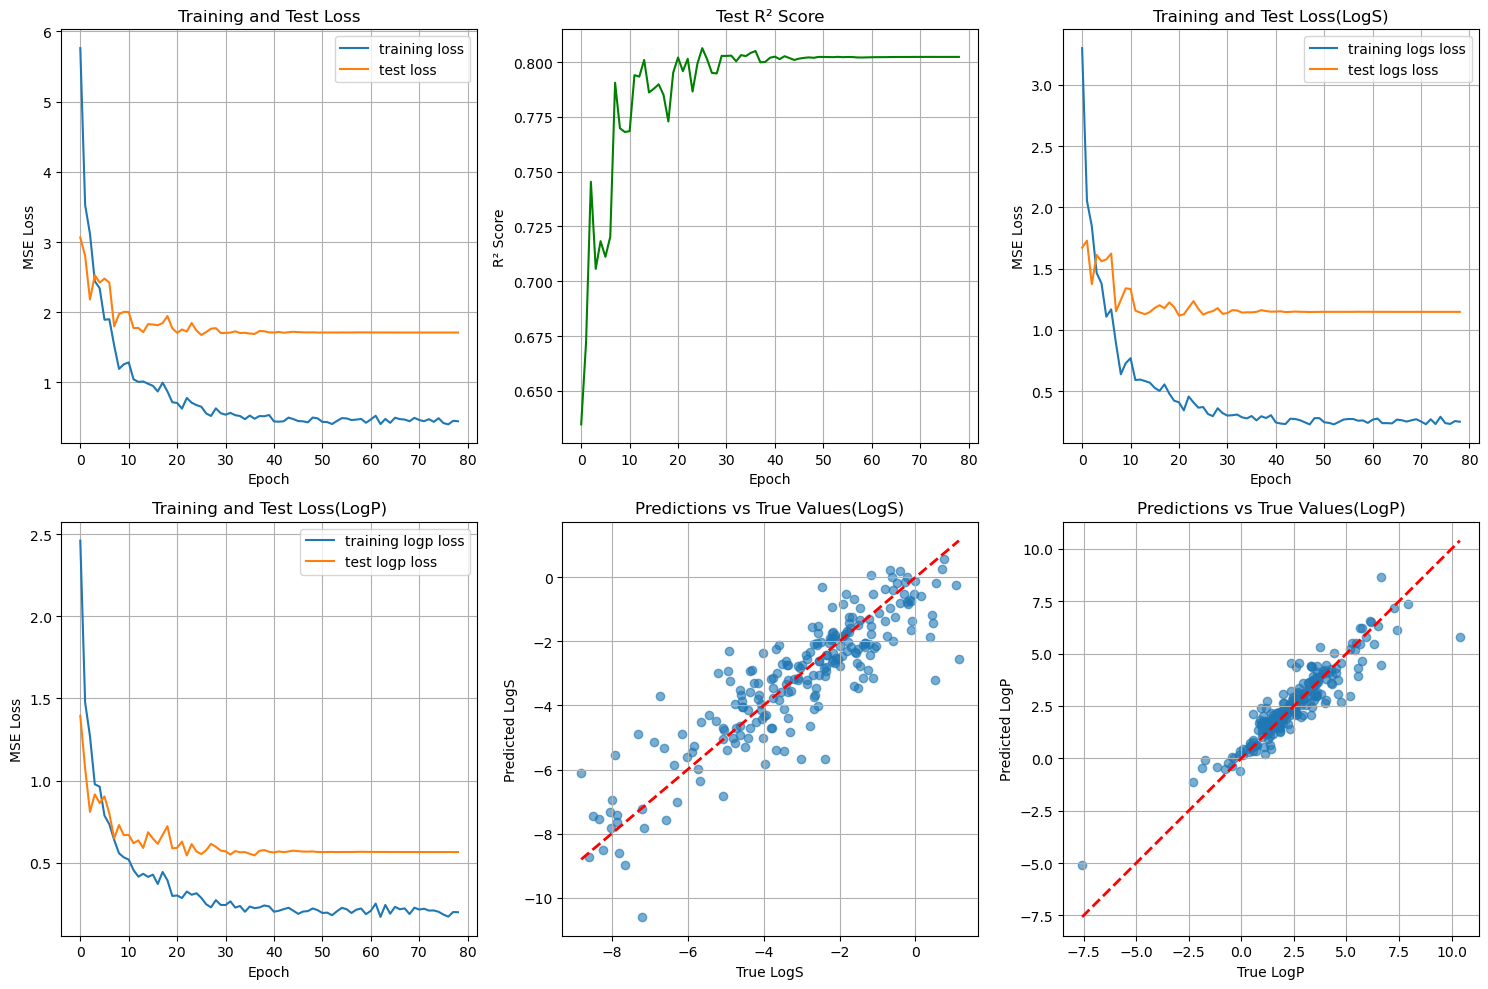

In [140]:
plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.plot(train_losses,label="training loss")
plt.plot(test_losses,label = "test loss")
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(test_r2_scores, label='Test R²', color='green')
plt.title('Test R² Score')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(train_logs_losses,label="training logs loss")
plt.plot(test_logs_losses,label = "test logs loss")
plt.title('Training and Test Loss(LogS)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(train_logp_losses,label="training logp loss")
plt.plot(test_logp_losses,label = "test logp loss")
plt.title('Training and Test Loss(LogP)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
# Final predictions vs actual
model = ANN3(input_channels=2048).to(device)
model.load_state_dict(torch.load('curr_ann.pth',weights_only=True))  # Load the best model
torch.save(model.state_dict(), 'ann3.pth')  # Save the best model
model.eval()
final_predictions = []
final_labels = []

with torch.no_grad():
    for fp, labels in test_loader:
        fp , labels = fp.float() , labels.float()
        fp, labels = fp.to(device), labels.to(device)
        outputs = model(fp)
        final_predictions.extend(outputs.cpu().numpy())
        final_labels.extend(labels.cpu().numpy())
final_predictions = np.array(final_predictions)
final_labels = np.array(final_labels)


plt.subplot(2, 3, 5)
plt.scatter(final_labels[:,0], final_predictions[:,0], alpha=0.6)
plt.plot([min(final_labels[:,0]), max(final_labels[:,0])],
         [min(final_labels[:,0]), max(final_labels[:,0])], 'r--', lw=2)
plt.xlabel('True LogS')
plt.ylabel('Predicted LogS')
plt.title('Predictions vs True Values(LogS)')
plt.grid(True)

plt.subplot(2, 3, 6)
plt.scatter(final_labels[:,1], final_predictions[:,1], alpha=0.6)
plt.plot([min(final_labels[:,1]), max(final_labels[:,1])],
         [min(final_labels[:,1]), max(final_labels[:,1])], 'r--', lw=2)
plt.xlabel('True LogP')
plt.ylabel('Predicted LogP')
plt.title('Predictions vs True Values(LogP)')
plt.grid(True)

plt.tight_layout()
plt.show()

### Storing Results

In [141]:
mae_logs = mean_absolute_error(final_labels[:,0], final_predictions[:,0])
print(f"MAE for LogS: {mae_logs:.4f}")
mae_logp = mean_absolute_error(final_labels[:,1], final_predictions[:,1])
print(f"MAE for LogP: {mae_logp:.4f}")
mse_logs = mean_squared_error(final_labels[:,0], final_predictions[:,0])
print(f"MSE for LogS: {mse_logs:.4f}")
mse_logp = mean_squared_error(final_labels[:,1], final_predictions[:,1])
print(f"MSE for LogP: {mse_logp:.4f}")
r2_logs = r2_score(final_labels[:,0], final_predictions[:,0])
print(f"R² for LogS: {r2_logs:.4f}")
r2_logp = r2_score(final_labels[:,1], final_predictions[:,1])
print(f"R² for LogP: {r2_logp:.4f}")
results['ANN3'] = {'MAE_LogS': mae_logs,'MAE_LogP': mae_logp,'MSE_LogS': mse_logs,'MSE_LogP': mse_logp,'r2_LogS': r2_logs,'r2_LogP': r2_logp}

MAE for LogS: 0.7920
MAE for LogP: 0.4933
MSE for LogS: 1.1238
MSE for LogP: 0.5525
R² for LogS: 0.7623
R² for LogP: 0.8505


### Comparing results of different models

In [142]:
print(f"LogS MAE :{results['ANN1']['MAE_LogS']:.4f}, {results['ANN2']['MAE_LogS']:.4f}, {results['ANN3']['MAE_LogS']:.4f}")
print(f"LogP MAE :{results['ANN1']['MAE_LogP']:.4f}, {results['ANN2']['MAE_LogP']:.4f}, {results['ANN3']['MAE_LogP']:.4f}")

LogS MAE :0.7482, 0.7520, 0.7920
LogP MAE :0.4699, 0.5006, 0.4933


Performance of model 1 is best. (However, not by much)

Adding more layers did not affect performance by a lot.

Also, all of our models suffered from overfitting. (Test MSE >> Training MSE).

(this is to be expected as we have a relatively small dataset of ~1k molecules)

(Also, our input (morgan fp) are very sparse as most of 2048 bits are set to 0)

(Also, as morgan fps are created through hashing, a bit does not have fixed meaning. A bit could be turned on because of 2 different substructures in 2 diff molecules)

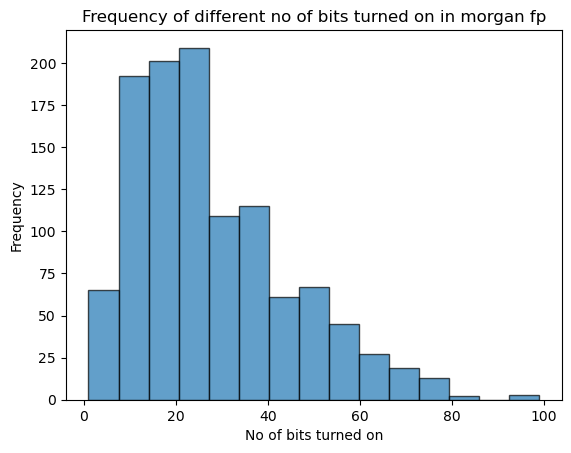

In [143]:
num_ones = [] #list containing no of ones in morgan fp of molecules
for _,row in df.iterrows():
    num_ones.append(np.sum(row['morgan']))
plt.title("Frequency of different no of bits turned on in morgan fp")
plt.hist(num_ones,bins=15,alpha=0.7,edgecolor='black')
plt.ylabel("Frequency")
plt.xlabel("No of bits turned on")
plt.show()

Hence,in most fingerprints only 0-60 bits are turned on out of 2048. Hence,our input is very sparse which could affect model performance.

# ANNs using MACCS keys

MACCs keys are substructure key based fingerprint , where each bit represents a particular substructure. 

They are of length 166. Also each bit has a fixed meaning corresponding to a particular substructure.

However, if a substructure is not part of those 166 pre-defined substructures, then they won't be encoded in the fingerprint.

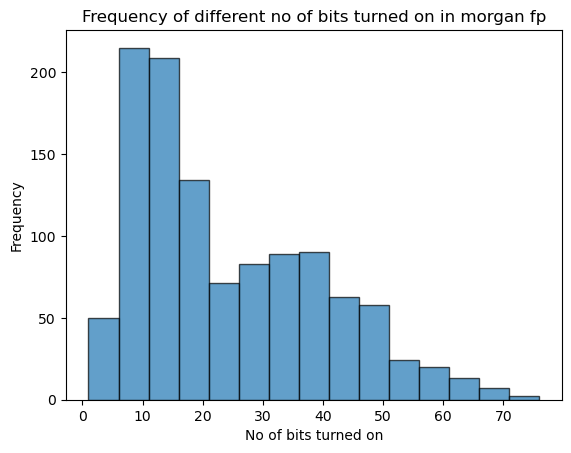

In [144]:
num_ones = [] #list containing no of ones in morgan fp of molecules
for _,row in df.iterrows():
    num_ones.append(np.sum(row['maccs']))
plt.title("Frequency of different no of bits turned on in morgan fp")
plt.hist(num_ones,bins=15,alpha=0.7,edgecolor='black')
plt.ylabel("Frequency")
plt.xlabel("No of bits turned on")
plt.show()

We can see that maccs fingerprints are comparatively less sparse as compared to morgan fingerprints, which could help model performance.

### Defining Dataset and Dataloaders

In [145]:
X_train, X_test, y_train, y_test = train_test_split(
    df['maccs'].values, df[['LogS','LogP']].values, #as we are predicting both LogS and LogP
    test_size=0.2, random_state=42
)
train_dataset = FPDataset(X_train,y_train)
test_dataset = FPDataset(X_test,y_test)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle = True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle = False)

# Defining Models

Simple ANN with just 1 hidden layer with 84 neurons.

In [146]:
class ANN4(nn.Module):
    def __init__(self,input_channels=167,num_classes=2):
        super(ANN4, self).__init__()
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_channels,84), #hidden layer 1
            nn.ReLU(),
            nn.Dropout(dropout_rate), #dropout for regularisation
            nn.Linear(84,2), # 2 outputs - logS and logP
        )
    def forward(self,x):
        y = self.regressor(x)
        return y

Simple ANN with 2 hidden layers :

Hidden layer 1 - 84 neurons

Hidden layer 2 - 42 neurons

In [147]:
class ANN5(nn.Module):
    def __init__(self,input_channels=167,num_classes=2):
        super(ANN5, self).__init__()
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_channels,84), #hidden layer 1
            nn.ReLU(),
            nn.Dropout(dropout_rate), #dropout for regularisation
            nn.Linear(84,42), #hidden layer 2
            nn.ReLU(),
            nn.Dropout(dropout_rate), #dropout for regularisation
            nn.Linear(42,2),
        )
    def forward(self,x):
        y = self.regressor(x)
        return y

## Training Models

### Model 1

In [148]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ANN4(input_channels=167).to(device)
print(device)
# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

cuda
Total parameters: 14,282
Trainable parameters: 14,282


In [149]:
train_losses, test_losses, test_r2_scores,train_logs_losses,train_logp_losses, test_logs_losses, test_logp_losses=train_model_regression(model,train_loader,test_loader,100)

testing: 100%|██████████| 226/226 [00:00<00:00, 2154.45it/s]


Epoch [1/100], Train Loss: 4.9705, Test Loss: 2.6710, Test R²: 0.6871, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2092.17it/s]


Epoch [2/100], Train Loss: 2.4418, Test Loss: 2.3678, Test R²: 0.7199, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1830.16it/s]


Epoch [3/100], Train Loss: 2.0844, Test Loss: 2.1377, Test R²: 0.7476, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1961.63it/s]


Epoch [4/100], Train Loss: 2.0026, Test Loss: 2.0239, Test R²: 0.7612, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1993.31it/s]


Epoch [5/100], Train Loss: 1.8321, Test Loss: 2.2978, Test R²: 0.7298, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1287.97it/s]


Epoch [6/100], Train Loss: 1.6900, Test Loss: 2.0567, Test R²: 0.7579, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1232.00it/s]


Epoch [7/100], Train Loss: 1.7004, Test Loss: 2.0754, Test R²: 0.7550, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1955.62it/s]


Epoch [8/100], Train Loss: 1.6612, Test Loss: 1.9812, Test R²: 0.7659, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2063.63it/s]


Epoch [9/100], Train Loss: 1.6008, Test Loss: 1.7664, Test R²: 0.7910, 


testing: 100%|██████████| 226/226 [00:00<00:00, 2020.24it/s]


Epoch [10/100], Train Loss: 1.5050, Test Loss: 1.8441, Test R²: 0.7835, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1768.20it/s]


Epoch [11/100], Train Loss: 1.4723, Test Loss: 1.9542, Test R²: 0.7702, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1929.29it/s]


Epoch [12/100], Train Loss: 1.4422, Test Loss: 1.9232, Test R²: 0.7711, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1521.05it/s]


Epoch [13/100], Train Loss: 1.3996, Test Loss: 1.8555, Test R²: 0.7811, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1914.09it/s]


Epoch [14/100], Train Loss: 1.2816, Test Loss: 1.6655, Test R²: 0.8033, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1732.88it/s]


Epoch [15/100], Train Loss: 1.2228, Test Loss: 1.6657, Test R²: 0.8035, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1481.63it/s]


Epoch [16/100], Train Loss: 1.2112, Test Loss: 1.6946, Test R²: 0.7998, 


testing: 100%|██████████| 226/226 [00:00<00:00, 594.27it/s]


Epoch [17/100], Train Loss: 1.1880, Test Loss: 1.6890, Test R²: 0.8007, 


testing: 100%|██████████| 226/226 [00:00<00:00, 597.38it/s]


Epoch [18/100], Train Loss: 1.1639, Test Loss: 1.5851, Test R²: 0.8125, 


testing: 100%|██████████| 226/226 [00:00<00:00, 619.46it/s]


Epoch [19/100], Train Loss: 1.1654, Test Loss: 1.7010, Test R²: 0.7996, 


testing: 100%|██████████| 226/226 [00:00<00:00, 599.22it/s]


Epoch [20/100], Train Loss: 1.0809, Test Loss: 1.6273, Test R²: 0.8074, 


testing: 100%|██████████| 226/226 [00:00<00:00, 618.89it/s]


Epoch [21/100], Train Loss: 1.1981, Test Loss: 1.6258, Test R²: 0.8078, 


testing: 100%|██████████| 226/226 [00:00<00:00, 627.37it/s]


Epoch [22/100], Train Loss: 1.1114, Test Loss: 1.6855, Test R²: 0.8015, 


testing: 100%|██████████| 226/226 [00:00<00:00, 609.00it/s]


Epoch [23/100], Train Loss: 1.0476, Test Loss: 1.5554, Test R²: 0.8165, 


testing: 100%|██████████| 226/226 [00:00<00:00, 591.03it/s]


Epoch [24/100], Train Loss: 1.0568, Test Loss: 1.5251, Test R²: 0.8200, 


testing: 100%|██████████| 226/226 [00:00<00:00, 676.16it/s]


Epoch [25/100], Train Loss: 1.0575, Test Loss: 1.6086, Test R²: 0.8102, 


testing: 100%|██████████| 226/226 [00:00<00:00, 638.81it/s]


Epoch [26/100], Train Loss: 1.0338, Test Loss: 1.6491, Test R²: 0.8058, 


testing: 100%|██████████| 226/226 [00:00<00:00, 631.28it/s]


Epoch [27/100], Train Loss: 1.0393, Test Loss: 1.5897, Test R²: 0.8127, 


testing: 100%|██████████| 226/226 [00:00<00:00, 592.43it/s]


Epoch [28/100], Train Loss: 0.9710, Test Loss: 1.6760, Test R²: 0.8028, 


testing: 100%|██████████| 226/226 [00:00<00:00, 614.89it/s]


Epoch [29/100], Train Loss: 0.9871, Test Loss: 1.5983, Test R²: 0.8116, 


testing: 100%|██████████| 226/226 [00:00<00:00, 594.04it/s]


Epoch [30/100], Train Loss: 1.0414, Test Loss: 1.5938, Test R²: 0.8121, 


testing: 100%|██████████| 226/226 [00:00<00:00, 561.10it/s]


Epoch [31/100], Train Loss: 0.9457, Test Loss: 1.5805, Test R²: 0.8136, 


testing: 100%|██████████| 226/226 [00:00<00:00, 532.67it/s]


Epoch [32/100], Train Loss: 0.9448, Test Loss: 1.5805, Test R²: 0.8136, 


testing: 100%|██████████| 226/226 [00:00<00:00, 535.76it/s]


Epoch [33/100], Train Loss: 0.9813, Test Loss: 1.5690, Test R²: 0.8149, 


testing: 100%|██████████| 226/226 [00:00<00:00, 587.51it/s]


Epoch [34/100], Train Loss: 0.9431, Test Loss: 1.5763, Test R²: 0.8140, 


testing: 100%|██████████| 226/226 [00:00<00:00, 617.43it/s]


Epoch [35/100], Train Loss: 0.9084, Test Loss: 1.5643, Test R²: 0.8154, 


testing: 100%|██████████| 226/226 [00:00<00:00, 462.95it/s]


Epoch [36/100], Train Loss: 0.9399, Test Loss: 1.5590, Test R²: 0.8160, 


testing: 100%|██████████| 226/226 [00:00<00:00, 599.46it/s]


Epoch [37/100], Train Loss: 0.9486, Test Loss: 1.5573, Test R²: 0.8162, 


testing: 100%|██████████| 226/226 [00:00<00:00, 646.91it/s]


Epoch [38/100], Train Loss: 0.8747, Test Loss: 1.5543, Test R²: 0.8166, 


testing: 100%|██████████| 226/226 [00:00<00:00, 653.69it/s]


Epoch [39/100], Train Loss: 0.9525, Test Loss: 1.5607, Test R²: 0.8159, 


testing: 100%|██████████| 226/226 [00:00<00:00, 675.69it/s]


Epoch [40/100], Train Loss: 0.9523, Test Loss: 1.5614, Test R²: 0.8158, 


testing: 100%|██████████| 226/226 [00:00<00:00, 640.31it/s]


Epoch [41/100], Train Loss: 0.9033, Test Loss: 1.5612, Test R²: 0.8159, 


testing: 100%|██████████| 226/226 [00:00<00:00, 622.34it/s]


Epoch [42/100], Train Loss: 0.9146, Test Loss: 1.5596, Test R²: 0.8160, 


testing: 100%|██████████| 226/226 [00:00<00:00, 646.22it/s]


Epoch [43/100], Train Loss: 0.9056, Test Loss: 1.5620, Test R²: 0.8158, 


testing: 100%|██████████| 226/226 [00:00<00:00, 601.82it/s]


Epoch [44/100], Train Loss: 0.9200, Test Loss: 1.5646, Test R²: 0.8155, 


testing: 100%|██████████| 226/226 [00:00<00:00, 692.61it/s]


Epoch [45/100], Train Loss: 0.8612, Test Loss: 1.5617, Test R²: 0.8158, 


testing: 100%|██████████| 226/226 [00:00<00:00, 642.32it/s]


Epoch [46/100], Train Loss: 0.9974, Test Loss: 1.5633, Test R²: 0.8156, 


testing: 100%|██████████| 226/226 [00:00<00:00, 644.98it/s]


Epoch [47/100], Train Loss: 0.9186, Test Loss: 1.5640, Test R²: 0.8155, 


testing: 100%|██████████| 226/226 [00:00<00:00, 613.62it/s]


Epoch [48/100], Train Loss: 0.9133, Test Loss: 1.5634, Test R²: 0.8156, 


testing: 100%|██████████| 226/226 [00:00<00:00, 694.95it/s]


Epoch [49/100], Train Loss: 0.9472, Test Loss: 1.5636, Test R²: 0.8156, 


testing: 100%|██████████| 226/226 [00:00<00:00, 650.10it/s]


Epoch [50/100], Train Loss: 0.8793, Test Loss: 1.5620, Test R²: 0.8158, 


testing: 100%|██████████| 226/226 [00:00<00:00, 698.39it/s]


Epoch [51/100], Train Loss: 0.9228, Test Loss: 1.5614, Test R²: 0.8158, 


testing: 100%|██████████| 226/226 [00:00<00:00, 652.57it/s]


Epoch [52/100], Train Loss: 0.9066, Test Loss: 1.5624, Test R²: 0.8157, 


testing: 100%|██████████| 226/226 [00:00<00:00, 701.01it/s]


Epoch [53/100], Train Loss: 0.9016, Test Loss: 1.5622, Test R²: 0.8158, 


testing: 100%|██████████| 226/226 [00:00<00:00, 635.57it/s]


Epoch [54/100], Train Loss: 0.9505, Test Loss: 1.5629, Test R²: 0.8157, 


testing: 100%|██████████| 226/226 [00:00<00:00, 641.81it/s]


Epoch [55/100], Train Loss: 0.9226, Test Loss: 1.5628, Test R²: 0.8157, 


testing: 100%|██████████| 226/226 [00:00<00:00, 621.40it/s]


Epoch [56/100], Train Loss: 0.9195, Test Loss: 1.5624, Test R²: 0.8157, 


testing: 100%|██████████| 226/226 [00:00<00:00, 433.09it/s]


Epoch [57/100], Train Loss: 0.9568, Test Loss: 1.5626, Test R²: 0.8157, 


testing: 100%|██████████| 226/226 [00:00<00:00, 603.92it/s]


Epoch [58/100], Train Loss: 0.9073, Test Loss: 1.5627, Test R²: 0.8157, 


testing: 100%|██████████| 226/226 [00:00<00:00, 675.34it/s]


Epoch [59/100], Train Loss: 0.8758, Test Loss: 1.5624, Test R²: 0.8157, 


testing: 100%|██████████| 226/226 [00:00<00:00, 556.74it/s]


Epoch [60/100], Train Loss: 0.9424, Test Loss: 1.5627, Test R²: 0.8157, 


testing: 100%|██████████| 226/226 [00:00<00:00, 668.94it/s]


Epoch [61/100], Train Loss: 0.8945, Test Loss: 1.5626, Test R²: 0.8157, 


testing: 100%|██████████| 226/226 [00:00<00:00, 614.09it/s]


Epoch [62/100], Train Loss: 0.8905, Test Loss: 1.5625, Test R²: 0.8157, 


testing: 100%|██████████| 226/226 [00:00<00:00, 484.24it/s]


Epoch [63/100], Train Loss: 0.9900, Test Loss: 1.5625, Test R²: 0.8157, 


testing: 100%|██████████| 226/226 [00:00<00:00, 646.73it/s]


Epoch [64/100], Train Loss: 0.9015, Test Loss: 1.5629, Test R²: 0.8157, 


testing: 100%|██████████| 226/226 [00:00<00:00, 581.70it/s]


Epoch [65/100], Train Loss: 0.9470, Test Loss: 1.5629, Test R²: 0.8157, 


testing: 100%|██████████| 226/226 [00:00<00:00, 626.64it/s]


Epoch [66/100], Train Loss: 0.9253, Test Loss: 1.5629, Test R²: 0.8157, 


testing: 100%|██████████| 226/226 [00:00<00:00, 667.49it/s]


Epoch [67/100], Train Loss: 0.8995, Test Loss: 1.5630, Test R²: 0.8157, 


testing: 100%|██████████| 226/226 [00:00<00:00, 586.52it/s]


Epoch [68/100], Train Loss: 0.8618, Test Loss: 1.5630, Test R²: 0.8157, 


testing: 100%|██████████| 226/226 [00:00<00:00, 603.89it/s]


Epoch [69/100], Train Loss: 0.9313, Test Loss: 1.5630, Test R²: 0.8157, 


testing: 100%|██████████| 226/226 [00:00<00:00, 615.85it/s]


Epoch [70/100], Train Loss: 0.9260, Test Loss: 1.5630, Test R²: 0.8157, 


testing: 100%|██████████| 226/226 [00:00<00:00, 629.95it/s]

Early stopping at epoch 71 due to no improvement in test loss.


## Visualising Results

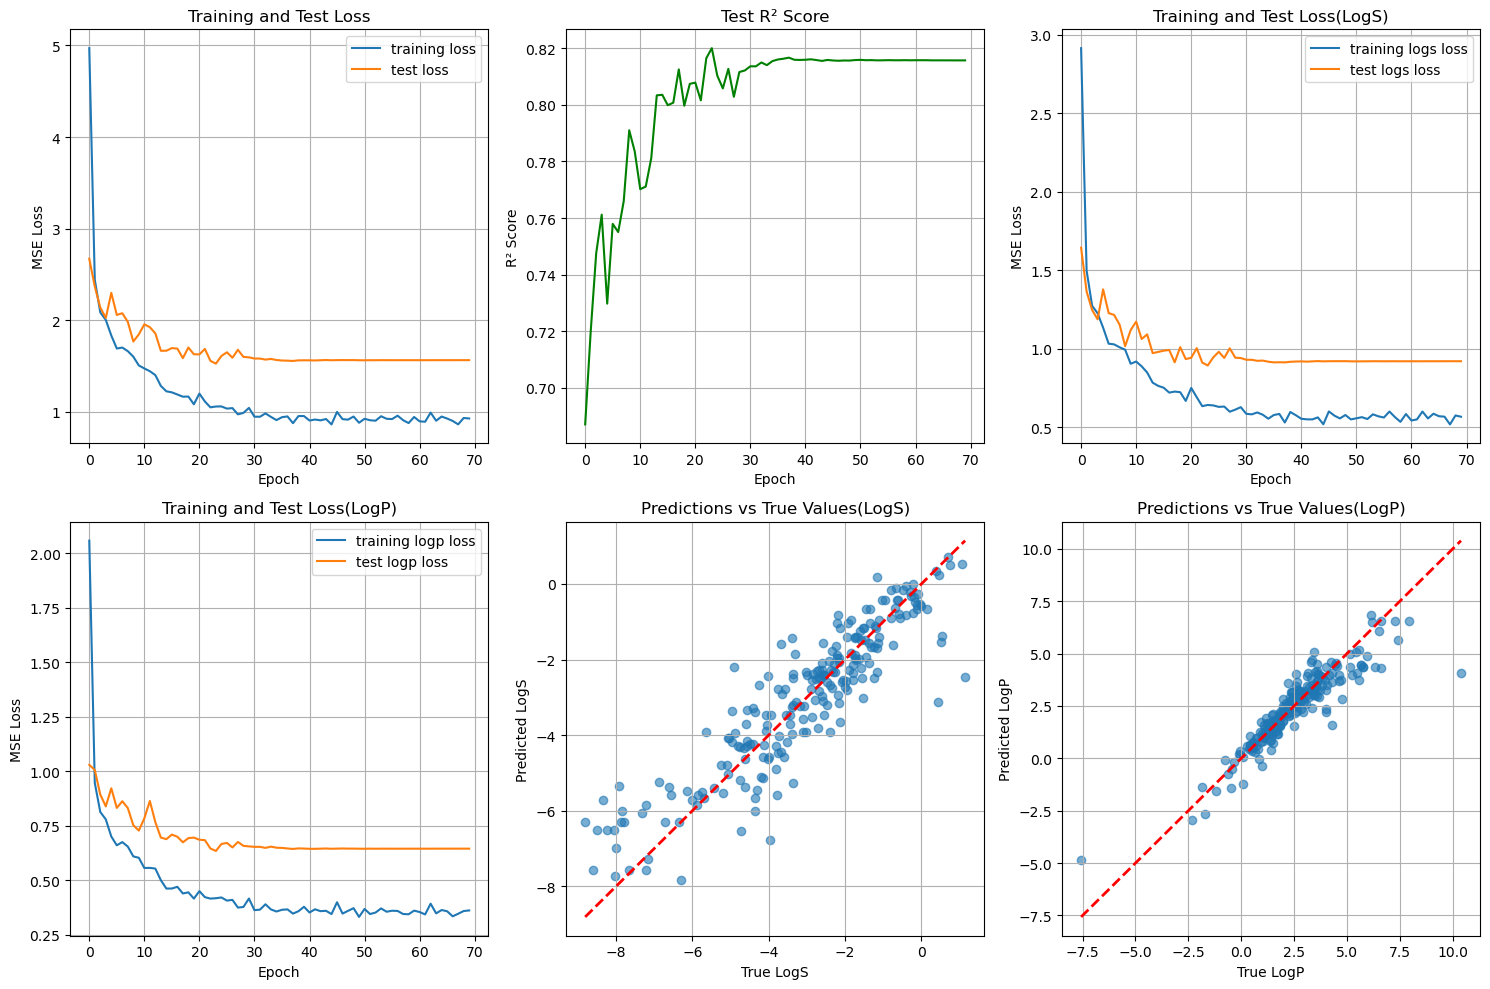

In [150]:
plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.plot(train_losses,label="training loss")
plt.plot(test_losses,label = "test loss")
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(test_r2_scores, label='Test R²', color='green')
plt.title('Test R² Score')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(train_logs_losses,label="training logs loss")
plt.plot(test_logs_losses,label = "test logs loss")
plt.title('Training and Test Loss(LogS)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(train_logp_losses,label="training logp loss")
plt.plot(test_logp_losses,label = "test logp loss")
plt.title('Training and Test Loss(LogP)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
# Final predictions vs actual
model = ANN4(input_channels=167).to(device)
model.load_state_dict(torch.load('curr_ann.pth',weights_only=True))  # Load the best model
torch.save(model.state_dict(), 'ann4.pth')  # Save the best model
model.eval()
final_predictions = []
final_labels = []

with torch.no_grad():
    for fp, labels in test_loader:
        fp , labels = fp.float() , labels.float()
        fp, labels = fp.to(device), labels.to(device)
        outputs = model(fp)
        final_predictions.extend(outputs.cpu().numpy())
        final_labels.extend(labels.cpu().numpy())
final_predictions = np.array(final_predictions)
final_labels = np.array(final_labels)


plt.subplot(2, 3, 5)
plt.scatter(final_labels[:,0], final_predictions[:,0], alpha=0.6)
plt.plot([min(final_labels[:,0]), max(final_labels[:,0])],
         [min(final_labels[:,0]), max(final_labels[:,0])], 'r--', lw=2)
plt.xlabel('True LogS')
plt.ylabel('Predicted LogS')
plt.title('Predictions vs True Values(LogS)')
plt.grid(True)

plt.subplot(2, 3, 6)
plt.scatter(final_labels[:,1], final_predictions[:,1], alpha=0.6)
plt.plot([min(final_labels[:,1]), max(final_labels[:,1])],
         [min(final_labels[:,1]), max(final_labels[:,1])], 'r--', lw=2)
plt.xlabel('True LogP')
plt.ylabel('Predicted LogP')
plt.title('Predictions vs True Values(LogP)')
plt.grid(True)

plt.tight_layout()
plt.show()

## Storing Results

In [151]:
mae_logs = mean_absolute_error(final_labels[:,0], final_predictions[:,0])
print(f"MAE for LogS: {mae_logs:.4f}")
mae_logp = mean_absolute_error(final_labels[:,1], final_predictions[:,1])
print(f"MAE for LogP: {mae_logp:.4f}")
mse_logs = mean_squared_error(final_labels[:,0], final_predictions[:,0])
print(f"MSE for LogS: {mse_logs:.4f}")
mse_logp = mean_squared_error(final_labels[:,1], final_predictions[:,1])
print(f"MSE for LogP: {mse_logp:.4f}")
r2_logs = r2_score(final_labels[:,0], final_predictions[:,0])
print(f"R² for LogS: {r2_logs:.4f}")
r2_logp = r2_score(final_labels[:,1], final_predictions[:,1])
print(f"R² for LogP: {r2_logp:.4f}")
results['ANN4'] = {'MAE_LogS': mae_logs,'MAE_LogP': mae_logp,'MSE_LogS': mse_logs,'MSE_LogP': mse_logp,'r2_LogS': r2_logs,'r2_LogP': r2_logp}

MAE for LogS: 0.6927
MAE for LogP: 0.4963
MSE for LogS: 0.8918
MSE for LogP: 0.6333
R² for LogS: 0.8113
R² for LogP: 0.8286


### Model 2

In [152]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ANN5(input_channels=167).to(device)
print(device)
# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

cuda
Total parameters: 17,768
Trainable parameters: 17,768


In [153]:
train_losses, test_losses, test_r2_scores,train_logs_losses,train_logp_losses, test_logs_losses, test_logp_losses=train_model_regression(model,train_loader,test_loader,100)

testing: 100%|██████████| 226/226 [00:00<00:00, 1448.40it/s]


Epoch [1/100], Train Loss: 5.1378, Test Loss: 2.6189, Test R²: 0.6888, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1745.60it/s]


Epoch [2/100], Train Loss: 2.9865, Test Loss: 2.5652, Test R²: 0.6979, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1810.33it/s]


Epoch [3/100], Train Loss: 2.5614, Test Loss: 2.3378, Test R²: 0.7245, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1757.52it/s]


Epoch [4/100], Train Loss: 2.4252, Test Loss: 2.0856, Test R²: 0.7557, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1938.60it/s]


Epoch [5/100], Train Loss: 2.1248, Test Loss: 2.3308, Test R²: 0.7248, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1781.76it/s]


Epoch [6/100], Train Loss: 2.2200, Test Loss: 1.9700, Test R²: 0.7704, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1885.80it/s]


Epoch [7/100], Train Loss: 1.9587, Test Loss: 1.9774, Test R²: 0.7659, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1839.84it/s]


Epoch [8/100], Train Loss: 1.9272, Test Loss: 1.8693, Test R²: 0.7811, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1870.48it/s]


Epoch [9/100], Train Loss: 1.8989, Test Loss: 1.9247, Test R²: 0.7745, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1814.15it/s]


Epoch [10/100], Train Loss: 1.7208, Test Loss: 1.8359, Test R²: 0.7842, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1885.92it/s]


Epoch [11/100], Train Loss: 1.8403, Test Loss: 1.9124, Test R²: 0.7738, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1704.42it/s]


Epoch [12/100], Train Loss: 1.6882, Test Loss: 1.7737, Test R²: 0.7908, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1878.48it/s]


Epoch [13/100], Train Loss: 1.7876, Test Loss: 1.8784, Test R²: 0.7790, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1668.05it/s]


Epoch [14/100], Train Loss: 1.8320, Test Loss: 1.6954, Test R²: 0.8007, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1636.30it/s]


Epoch [15/100], Train Loss: 1.6943, Test Loss: 1.8886, Test R²: 0.7799, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1908.96it/s]


Epoch [16/100], Train Loss: 1.6790, Test Loss: 1.8362, Test R²: 0.7849, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1630.72it/s]


Epoch [17/100], Train Loss: 1.6277, Test Loss: 1.6416, Test R²: 0.8073, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1478.04it/s]


Epoch [18/100], Train Loss: 1.5191, Test Loss: 1.8680, Test R²: 0.7812, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1679.47it/s]


Epoch [19/100], Train Loss: 1.5244, Test Loss: 2.0726, Test R²: 0.7545, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1829.80it/s]


Epoch [20/100], Train Loss: 1.4582, Test Loss: 1.6751, Test R²: 0.8036, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1639.38it/s]


Epoch [21/100], Train Loss: 1.4862, Test Loss: 2.0197, Test R²: 0.7632, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1627.41it/s]


Epoch [22/100], Train Loss: 1.3340, Test Loss: 1.6144, Test R²: 0.8098, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1685.19it/s]


Epoch [23/100], Train Loss: 1.2386, Test Loss: 1.6553, Test R²: 0.8050, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1812.08it/s]


Epoch [24/100], Train Loss: 1.1980, Test Loss: 1.6652, Test R²: 0.8034, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1857.45it/s]


Epoch [25/100], Train Loss: 1.2723, Test Loss: 1.6744, Test R²: 0.8019, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1593.40it/s]


Epoch [26/100], Train Loss: 1.2279, Test Loss: 1.6620, Test R²: 0.8037, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1701.47it/s]


Epoch [27/100], Train Loss: 1.2519, Test Loss: 1.5997, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1655.57it/s]


Epoch [28/100], Train Loss: 1.2413, Test Loss: 1.6082, Test R²: 0.8101, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1707.55it/s]


Epoch [29/100], Train Loss: 1.1368, Test Loss: 1.6701, Test R²: 0.8033, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1548.76it/s]


Epoch [30/100], Train Loss: 1.0395, Test Loss: 1.6942, Test R²: 0.8008, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1456.11it/s]


Epoch [31/100], Train Loss: 0.9910, Test Loss: 1.6702, Test R²: 0.8030, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1631.58it/s]


Epoch [32/100], Train Loss: 1.1087, Test Loss: 1.5742, Test R²: 0.8144, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1724.92it/s]


Epoch [33/100], Train Loss: 1.0288, Test Loss: 1.6393, Test R²: 0.8065, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1770.15it/s]


Epoch [34/100], Train Loss: 1.0328, Test Loss: 1.6045, Test R²: 0.8108, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1679.74it/s]


Epoch [35/100], Train Loss: 0.9875, Test Loss: 1.6192, Test R²: 0.8094, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1639.90it/s]


Epoch [36/100], Train Loss: 1.0381, Test Loss: 1.6381, Test R²: 0.8070, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1528.94it/s]


Epoch [37/100], Train Loss: 1.0269, Test Loss: 1.6183, Test R²: 0.8091, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1746.21it/s]


Epoch [38/100], Train Loss: 1.0129, Test Loss: 1.5909, Test R²: 0.8125, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1548.52it/s]


Epoch [39/100], Train Loss: 1.0460, Test Loss: 1.6175, Test R²: 0.8093, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1585.90it/s]


Epoch [40/100], Train Loss: 0.9812, Test Loss: 1.6083, Test R²: 0.8104, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1733.83it/s]


Epoch [41/100], Train Loss: 1.0516, Test Loss: 1.6077, Test R²: 0.8104, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1538.63it/s]


Epoch [42/100], Train Loss: 0.9177, Test Loss: 1.6057, Test R²: 0.8107, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1599.79it/s]


Epoch [43/100], Train Loss: 1.0382, Test Loss: 1.5984, Test R²: 0.8115, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1739.35it/s]


Epoch [44/100], Train Loss: 0.9678, Test Loss: 1.5920, Test R²: 0.8123, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1660.27it/s]


Epoch [45/100], Train Loss: 0.9164, Test Loss: 1.6016, Test R²: 0.8113, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1672.67it/s]


Epoch [46/100], Train Loss: 1.0534, Test Loss: 1.5946, Test R²: 0.8121, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1758.45it/s]


Epoch [47/100], Train Loss: 0.9052, Test Loss: 1.6005, Test R²: 0.8114, 


testing: 100%|██████████| 226/226 [00:00<00:00, 1623.38it/s]


Epoch [48/100], Train Loss: 0.9570, Test Loss: 1.6020, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 957.35it/s] 


Epoch [49/100], Train Loss: 0.9189, Test Loss: 1.6049, Test R²: 0.8109, 


testing: 100%|██████████| 226/226 [00:00<00:00, 521.45it/s]


Epoch [50/100], Train Loss: 0.9605, Test Loss: 1.6048, Test R²: 0.8109, 


testing: 100%|██████████| 226/226 [00:00<00:00, 502.75it/s]


Epoch [51/100], Train Loss: 1.0019, Test Loss: 1.6049, Test R²: 0.8108, 


testing: 100%|██████████| 226/226 [00:00<00:00, 509.63it/s]


Epoch [52/100], Train Loss: 1.0053, Test Loss: 1.6061, Test R²: 0.8107, 


testing: 100%|██████████| 226/226 [00:00<00:00, 527.04it/s]


Epoch [53/100], Train Loss: 1.0389, Test Loss: 1.6076, Test R²: 0.8105, 


testing: 100%|██████████| 226/226 [00:00<00:00, 555.45it/s]


Epoch [54/100], Train Loss: 0.9229, Test Loss: 1.6062, Test R²: 0.8107, 


testing: 100%|██████████| 226/226 [00:00<00:00, 513.86it/s]


Epoch [55/100], Train Loss: 0.8868, Test Loss: 1.6048, Test R²: 0.8108, 


testing: 100%|██████████| 226/226 [00:00<00:00, 571.53it/s]


Epoch [56/100], Train Loss: 0.9845, Test Loss: 1.6027, Test R²: 0.8111, 


testing: 100%|██████████| 226/226 [00:00<00:00, 586.09it/s]


Epoch [57/100], Train Loss: 1.0478, Test Loss: 1.6024, Test R²: 0.8111, 


testing: 100%|██████████| 226/226 [00:00<00:00, 513.29it/s]


Epoch [58/100], Train Loss: 0.9498, Test Loss: 1.6014, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 541.82it/s]


Epoch [59/100], Train Loss: 1.0025, Test Loss: 1.6007, Test R²: 0.8113, 


testing: 100%|██████████| 226/226 [00:00<00:00, 626.32it/s]


Epoch [60/100], Train Loss: 1.0084, Test Loss: 1.6008, Test R²: 0.8113, 


testing: 100%|██████████| 226/226 [00:00<00:00, 637.84it/s]


Epoch [61/100], Train Loss: 0.9867, Test Loss: 1.6009, Test R²: 0.8113, 


testing: 100%|██████████| 226/226 [00:00<00:00, 472.47it/s]


Epoch [62/100], Train Loss: 0.9525, Test Loss: 1.6010, Test R²: 0.8113, 


testing: 100%|██████████| 226/226 [00:00<00:00, 505.94it/s]


Epoch [63/100], Train Loss: 0.9413, Test Loss: 1.6005, Test R²: 0.8113, 


testing: 100%|██████████| 226/226 [00:00<00:00, 493.94it/s]


Epoch [64/100], Train Loss: 0.9085, Test Loss: 1.6010, Test R²: 0.8113, 


testing: 100%|██████████| 226/226 [00:00<00:00, 554.84it/s]


Epoch [65/100], Train Loss: 1.0739, Test Loss: 1.6013, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 496.94it/s]


Epoch [66/100], Train Loss: 0.9675, Test Loss: 1.6014, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 524.04it/s]


Epoch [67/100], Train Loss: 1.0236, Test Loss: 1.6016, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 837.55it/s]


Epoch [68/100], Train Loss: 0.9393, Test Loss: 1.6015, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 492.44it/s]


Epoch [69/100], Train Loss: 0.9228, Test Loss: 1.6014, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 540.95it/s]


Epoch [70/100], Train Loss: 1.0331, Test Loss: 1.6014, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 566.33it/s]


Epoch [71/100], Train Loss: 0.9540, Test Loss: 1.6016, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 535.31it/s]


Epoch [72/100], Train Loss: 0.9706, Test Loss: 1.6013, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 523.08it/s]


Epoch [73/100], Train Loss: 1.0464, Test Loss: 1.6013, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 485.35it/s]


Epoch [74/100], Train Loss: 0.9270, Test Loss: 1.6013, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 534.20it/s]


Epoch [75/100], Train Loss: 0.9191, Test Loss: 1.6014, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 517.08it/s]


Epoch [76/100], Train Loss: 1.0222, Test Loss: 1.6013, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 516.35it/s]


Epoch [77/100], Train Loss: 0.9995, Test Loss: 1.6013, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 470.46it/s]


Epoch [78/100], Train Loss: 0.9880, Test Loss: 1.6013, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 518.52it/s]


Epoch [79/100], Train Loss: 1.0018, Test Loss: 1.6013, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 514.40it/s]


Epoch [80/100], Train Loss: 0.9595, Test Loss: 1.6013, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 556.91it/s]


Epoch [81/100], Train Loss: 0.9966, Test Loss: 1.6013, Test R²: 0.8112, 


testing: 100%|██████████| 226/226 [00:00<00:00, 519.13it/s]

Early stopping at epoch 82 due to no improvement in test loss.


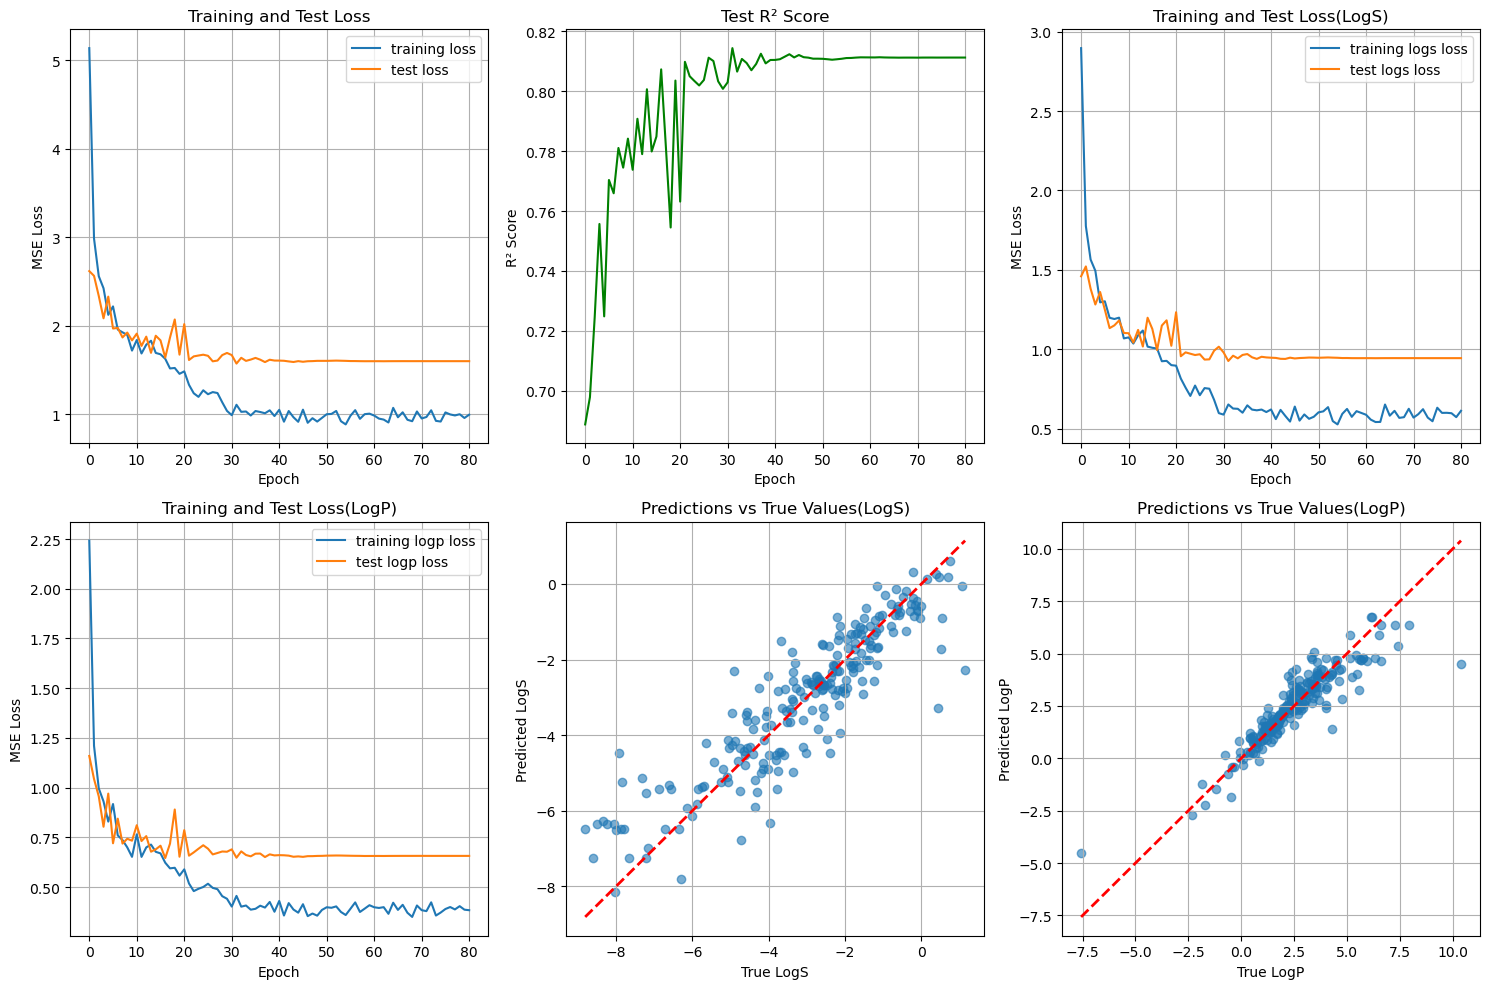

In [154]:
plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.plot(train_losses,label="training loss")
plt.plot(test_losses,label = "test loss")
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(test_r2_scores, label='Test R²', color='green')
plt.title('Test R² Score')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(train_logs_losses,label="training logs loss")
plt.plot(test_logs_losses,label = "test logs loss")
plt.title('Training and Test Loss(LogS)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(train_logp_losses,label="training logp loss")
plt.plot(test_logp_losses,label = "test logp loss")
plt.title('Training and Test Loss(LogP)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
# Final predictions vs actual
model = ANN5(input_channels=167).to(device)
model.load_state_dict(torch.load('curr_ann.pth',weights_only=True))  # Load the best model
torch.save(model.state_dict(), 'ann5.pth')  # Save the best model
model.eval()
final_predictions = []
final_labels = []

with torch.no_grad():
    for fp, labels in test_loader:
        fp , labels = fp.float() , labels.float()
        fp, labels = fp.to(device), labels.to(device)
        outputs = model(fp)
        final_predictions.extend(outputs.cpu().numpy())
        final_labels.extend(labels.cpu().numpy())
final_predictions = np.array(final_predictions)
final_labels = np.array(final_labels)


plt.subplot(2, 3, 5)
plt.scatter(final_labels[:,0], final_predictions[:,0], alpha=0.6)
plt.plot([min(final_labels[:,0]), max(final_labels[:,0])],
         [min(final_labels[:,0]), max(final_labels[:,0])], 'r--', lw=2)
plt.xlabel('True LogS')
plt.ylabel('Predicted LogS')
plt.title('Predictions vs True Values(LogS)')
plt.grid(True)

plt.subplot(2, 3, 6)
plt.scatter(final_labels[:,1], final_predictions[:,1], alpha=0.6)
plt.plot([min(final_labels[:,1]), max(final_labels[:,1])],
         [min(final_labels[:,1]), max(final_labels[:,1])], 'r--', lw=2)
plt.xlabel('True LogP')
plt.ylabel('Predicted LogP')
plt.title('Predictions vs True Values(LogP)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [155]:
mae_logs = mean_absolute_error(final_labels[:,0], final_predictions[:,0])
print(f"MAE for LogS: {mae_logs:.4f}")
mae_logp = mean_absolute_error(final_labels[:,1], final_predictions[:,1])
print(f"MAE for LogP: {mae_logp:.4f}")
mse_logs = mean_squared_error(final_labels[:,0], final_predictions[:,0])
print(f"MSE for LogS: {mse_logs:.4f}")
mse_logp = mean_squared_error(final_labels[:,1], final_predictions[:,1])
print(f"MSE for LogP: {mse_logp:.4f}")
r2_logs = r2_score(final_labels[:,0], final_predictions[:,0])
print(f"R² for LogS: {r2_logs:.4f}")
r2_logp = r2_score(final_labels[:,1], final_predictions[:,1])
print(f"R² for LogP: {r2_logp:.4f}")
results['ANN5'] = {'MAE_LogS': mae_logs,'MAE_LogP': mae_logp,'MSE_LogS': mse_logs,'MSE_LogP': mse_logp,'r2_LogS': r2_logs,'r2_LogP': r2_logp}

MAE for LogS: 0.6951
MAE for LogP: 0.5205
MSE for LogS: 0.9266
MSE for LogP: 0.6476
R² for LogS: 0.8040
R² for LogP: 0.8248


## Comparing results of all models

Text(0, 0.5, 'MAE')

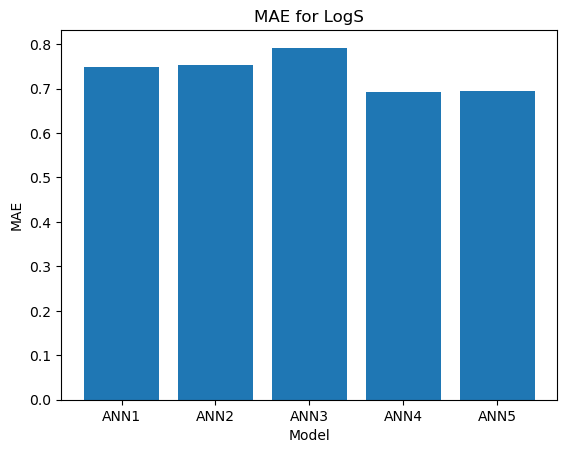

In [156]:
plt.bar(range(len(results)), [results[key]['MAE_LogS'] for key in results], tick_label=list(results.keys()))
plt.title('MAE for LogS')
plt.xlabel('Model')
plt.ylabel('MAE')

Text(0, 0.5, 'MAE')

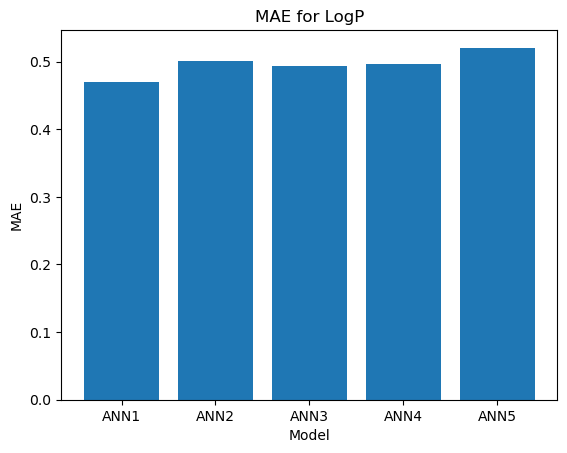

In [157]:
plt.bar(range(len(results)), [results[key]['MAE_LogP'] for key in results], tick_label=list(results.keys()))
plt.title('MAE for LogP')
plt.xlabel('Model')
plt.ylabel('MAE')

Model with MACCS Keys as input perform similarly to model with morgan fingerprint, despite being of much shorter length(167 vs 2048).

Moreover, overfitting is also less in model with MACCS keys as input as input is less sparse.